Projet (besoin, context, ...)

## 1. Chargement et Préparation des Données

### 1.1 Importation des données

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


### 1.2 Load and Merge Data (Charger et Fusionner les Données)
Objectif : Charger tous les fichiers CSV, puis fusionner les données sur EmployeeID.

In [249]:

employee_df = pd.read_csv("data/employee_survey_data.csv")
general_df = pd.read_csv("data/general_data.csv")
manager_df = pd.read_csv("data/manager_survey_data.csv")
in_time_df = pd.read_csv("data/in_time.csv")
out_time_df = pd.read_csv("data/out_time.csv")

# Merge employee_df and general_df on EmployeeID
merged_df = pd.merge(employee_df, general_df, on="EmployeeID", how="inner")

# Merge in manager_df
merged_df = pd.merge(merged_df, manager_df, on="EmployeeID", how="inner")


# Afficher un aperçu
print(merged_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Age                      4410 non-null   int64  
 5   Attrition                4410 non-null   object 
 6   BusinessTravel           4410 non-null   object 
 7   Department               4410 non-null   object 
 8   DistanceFromHome         4410 non-null   int64  
 9   Education                4410 non-null   int64  
 10  EducationField           4410 non-null   object 
 11  EmployeeCount            4410 non-null   int64  
 12  Gender                   4410 non-null   object 
 13  JobLevel                 4410 non-null   int64  
 14  JobRole                 

### 1.3 Supprission des Colonnes Inutiles/Sensibles
Objectif : Supprimer les colonnes qui n'apportent pas d'informations utiles à l'analyse.
#### Colonnes à supprimer :
- Over18 : Tous les employés ont plus de 18 ans.
- EmployeeCount : Toujours égal à 1 (inutile).
- StandardHours : Toujours égal à 8 (inutile).

Remarque: La colonne "Gender" est laissé pour tester son impact sur le resultat.

In [250]:
# Supprimer les colonnes inutiles
columns_to_drop = ["EmployeeCount", "Over18", "StandardHours"]
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True, errors="ignore")
# Visualiser apres suppression de quelques colonnes
print(merged_df.head())

   EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  Age  \
0           1                      3.0              4.0              2.0   51   
1           2                      3.0              2.0              4.0   31   
2           3                      2.0              2.0              1.0   32   
3           4                      4.0              4.0              3.0   38   
4           5                      4.0              1.0              3.0   32   

  Attrition     BusinessTravel              Department  DistanceFromHome  \
0        No      Travel_Rarely                   Sales                 6   
1       Yes  Travel_Frequently  Research & Development                10   
2        No  Travel_Frequently  Research & Development                17   
3        No         Non-Travel  Research & Development                 2   
4        No      Travel_Rarely  Research & Development                10   

   Education  ... NumCompaniesWorked PercentSalaryHike  

### 1.4 Nettoyage et Préparation des Données de Temps
Objectif : Transformer les fichiers in_time et out_time pour obtenir le nombre d'heures travaillées.

#### Actions :
- Convertir les dates en format datetime.
- Calculer la durée travaillée chaque jour (out_time - in_time).
- Calculer la moyenne des heures travaillées pour chaque employé.

In [251]:
# Rename 'Unnamed: 0' to 'EmployeeID' for easier merging
in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

# We’ll create a separate DataFrame that holds each employee’s average work hours
# Convert time columns to datetime (ignore errors if any NaNs or incorrect formats appear)
time_cols = in_time_df.columns[1:]  # skip EmployeeID column
in_time_df[time_cols] = in_time_df[time_cols].apply(pd.to_datetime, errors="coerce")
out_time_df[time_cols] = out_time_df[time_cols].apply(pd.to_datetime, errors="coerce")

# Calculate the daily hours as OUT - IN
# This returns a DataFrame of timedeltas; convert to hours by dividing total_seconds by 3600
daily_hours = out_time_df[time_cols].sub(in_time_df[time_cols])
daily_hours = daily_hours.apply(lambda row: row.dt.total_seconds() / 3600)

# Create average hours feature per employee
avg_hours_df = pd.DataFrame({
    "EmployeeID": in_time_df["EmployeeID"],
    "AverageWorkHours": daily_hours.mean(axis=1)  # mean across all days
})

# Merge avg_hours_df with merged_df
if "AverageWorkHours" in merged_df.columns:
    merged_df.drop(columns=["AverageWorkHours"], inplace=True)


In [252]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Age                      4410 non-null   int64  
 5   Attrition                4410 non-null   object 
 6   BusinessTravel           4410 non-null   object 
 7   Department               4410 non-null   object 
 8   DistanceFromHome         4410 non-null   int64  
 9   Education                4410 non-null   int64  
 10  EducationField           4410 non-null   object 
 11  Gender                   4410 non-null   object 
 12  JobLevel                 4410 non-null   int64  
 13  JobRole                  4410 non-null   object 
 14  MaritalStatus           

### 1.5 Fusionner les Données de Temps dans le Dataset Principal
**Objectif** : Ajouter la colonne AverageWorkHours au dataset fusionné.

In [253]:
# Fusionner les données de temps avec le dataset principal
final_df = pd.merge(merged_df, avg_hours_df, on="EmployeeID", how="left")

# Vérifier les mises à jour
print(final_df.columns)


Index(['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'Gender', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating',
       'AverageWorkHours'],
      dtype='object')


### 1.6 Créer ou Transformer des Variables Intéressantes
**Objectif** : Transformer les variables en formats exploitables pour l’analyse et les modèles.

#### Transformations importantes :
- Encodage de Attrition : Convertir Yes/No en 1/0.
- Remplacer les valeurs manquantes (NA) dans employee_survey_data.csv par la médiane.
- Encodage des variables catégorielles (BusinessTravel, EducationField, etc.).
- Création d'une variable YearsSinceLastPromotionRatio : YearsSinceLastPromotion / YearsAtCompany.

In [254]:
# Transformer la colonne 'Attrition' en variable binaire
final_df["Attrition"] = final_df["Attrition"].map({"No": 0, "Yes": 1})

# Créer une variable 'YearsSinceLastPromotionRatio'
final_df["YearsSinceLastPromotionRatio"] = final_df["YearsSinceLastPromotion"] / (final_df["YearsAtCompany"] + 1)

# Vérifier les mises à jour
print(final_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   EmployeeID                    4410 non-null   int64  
 1   EnvironmentSatisfaction       4385 non-null   float64
 2   JobSatisfaction               4390 non-null   float64
 3   WorkLifeBalance               4372 non-null   float64
 4   Age                           4410 non-null   int64  
 5   Attrition                     4410 non-null   int64  
 6   BusinessTravel                4410 non-null   object 
 7   Department                    4410 non-null   object 
 8   DistanceFromHome              4410 non-null   int64  
 9   Education                     4410 non-null   int64  
 10  EducationField                4410 non-null   object 
 11  Gender                        4410 non-null   object 
 12  JobLevel                      4410 non-null   int64  
 13  Job

### 1. Gestion des valeurs manquantes

In [255]:
# Vérifier les valeurs manquantes
final_df.isnull().sum()

EmployeeID                       0
EnvironmentSatisfaction         25
JobSatisfaction                 20
WorkLifeBalance                 38
Age                              0
Attrition                        0
BusinessTravel                   0
Department                       0
DistanceFromHome                 0
Education                        0
EducationField                   0
Gender                           0
JobLevel                         0
JobRole                          0
MaritalStatus                    0
MonthlyIncome                    0
NumCompaniesWorked              19
PercentSalaryHike                0
StockOptionLevel                 0
TotalWorkingYears                9
TrainingTimesLastYear            0
YearsAtCompany                   0
YearsSinceLastPromotion          0
YearsWithCurrManager             0
JobInvolvement                   0
PerformanceRating                0
AverageWorkHours                 0
YearsSinceLastPromotionRatio     0
dtype: int64

In [256]:
final_df.drop(columns=["EmployeeID"], inplace=True)

# Imputer les valeurs manquantes pour les variables numériques avec la médiane
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Sélection des colonnes numériques
df_num = final_df.select_dtypes(include=[float, int])
imputer.fit(df_num)

# Remplacement des valeurs manquantes
df_num_imputed = pd.DataFrame(imputer.transform(df_num), columns=df_num.columns)

# Vérifier s'il reste des valeurs manquantes
df_num_imputed.isnull().sum()

EnvironmentSatisfaction         0
JobSatisfaction                 0
WorkLifeBalance                 0
Age                             0
Attrition                       0
DistanceFromHome                0
Education                       0
JobLevel                        0
MonthlyIncome                   0
NumCompaniesWorked              0
PercentSalaryHike               0
StockOptionLevel                0
TotalWorkingYears               0
TrainingTimesLastYear           0
YearsAtCompany                  0
YearsSinceLastPromotion         0
YearsWithCurrManager            0
JobInvolvement                  0
PerformanceRating               0
AverageWorkHours                0
YearsSinceLastPromotionRatio    0
dtype: int64

### 2. Encodage des variables catégorielles

In [257]:
# Sélection des colonnes catégorielles
df_cat = final_df.select_dtypes(include=[object, bool])

# Encodage one-hot des variables catégorielles
df_cat_encoded = pd.get_dummies(df_cat)

# Vérification du résultat de l'encodage
df_cat_encoded.head()

BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
0                      False                             False   
1                      False                              True   
2                      False                              True   
3                       True                             False   
4                      False                             False   

   BusinessTravel_Travel_Rarely  Department_Human Resources  \
0                          True                       False   
1                         False                       False   
2                         False                       False   
3                         False                       False   
4                          True                       False   

   Department_Research & Development  Department_Sales  \
0                              False              True   
1                               True             False   
2                               True             False   
3                               True             False   
4                               True             False   

   EducationField_Human Resources  EducationField_Life Sciences  \
0                           False                          True   
1                           False                          True   
2                           False                         False   
3                           False                          True   
4                           False                         False   

   EducationField_Marketing  EducationField_Medical  ...  \
0                     False                   False  ...   
1                     False                   False  ...   
2                     False                   False  ...   
3                     False                   False  ...   
4                     False                    True  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                          False            False   
1                          False            False   
2                          False            False   
3                          False            False   
4                          False            False   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                           False                      False   
1                           False                      False   
2                           False                      False   
3                           False                      False   
4                           False                      False   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                       False                    False   
1                        True                    False   
2                       False                     True   
3                       False                    False   
4                       False                     True   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                         False                   False   
1                         False                   False   
2                         False                   False   
3                         False                   False   
4                         False                   False   

   MaritalStatus_Married  MaritalStatus_Single  
0                   True                 False  
1                  False                  True  
2                   True                 False  
3                   True                 False  
4                  False                  True  

[5 rows x 26 columns]

### 3. Normalization des données

In [258]:
# Normalisation des colonnes numériques
scaler = StandardScaler()
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num_imputed), columns=df_num_imputed.columns)

# Vérification de la normalisation
df_num_scaled.head()

EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance       Age  \
0                 0.252200         1.156302        -1.085336  1.541369   
1                 0.252200        -0.663899         1.757749 -0.648668   
2                -0.665460        -0.663899        -2.506879 -0.539166   
3                 1.169861         1.156302         0.336206  0.117845   
4                 1.169861        -1.573999         0.336206 -0.539166   

   Attrition  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
0  -0.438422         -0.393938  -0.891688 -0.961486       1.405136   
1   2.280906          0.099639  -1.868426 -0.961486      -0.491661   
2  -0.438422          0.963398   1.061787  1.749610       2.725053   
3  -0.438422         -0.887515   2.038524  0.845911       0.386301   
4  -0.438422          0.099639  -1.868426 -0.961486      -0.884109   

   NumCompaniesWorked  ...  StockOptionLevel  TotalWorkingYears  \
0           -0.678464  ...         -0.932014          -1.322079   
1           -1.079486  ...          0.241988          -0.678877   
2           -0.678464  ...          2.589994          -0.807517   
3            0.123580  ...          2.589994           0.221606   
4            0.524602  ...          1.415991          -0.292956   

   TrainingTimesLastYear  YearsAtCompany  YearsSinceLastPromotion  \
0               2.483396       -0.981014                -0.679146   
1               0.155707       -0.327893                -0.368715   
2              -0.620189       -0.327893                -0.679146   
3               1.707500        0.161947                 1.493867   
4              -0.620189       -0.164613                -0.679146   

   YearsWithCurrManager  JobInvolvement  PerformanceRating  AverageWorkHours  \
0             -1.155935        0.379672          -0.426230         -0.244123   
1             -0.034520       -1.026167           2.346151          0.013564   
2             -0.314873        0.379672          -0.426230         -0.513073   
3              0.245834       -1.026167          -0.426230         -0.378424   
4             -0.034520        0.379672          -0.426230          0.227886   

   YearsSinceLastPromotionRatio  
0                     -0.878153  
1                     -0.259189  
2                     -0.878153  
3                      2.010349  
4                     -0.878153  

[5 rows x 21 columns]

### 4. Assemblage des données préparées

In [259]:
# Concatenation des colonnes numériques normalisées et des colonnes catégorielles encodées
df_prepared = pd.concat([df_num_scaled, df_cat_encoded], axis=1)
df_prepared["Attrition"] = final_df["Attrition"]
# Vérification des données préparées
df_prepared.head()

EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance       Age  \
0                 0.252200         1.156302        -1.085336  1.541369   
1                 0.252200        -0.663899         1.757749 -0.648668   
2                -0.665460        -0.663899        -2.506879 -0.539166   
3                 1.169861         1.156302         0.336206  0.117845   
4                 1.169861        -1.573999         0.336206 -0.539166   

   Attrition  DistanceFromHome  Education  JobLevel  MonthlyIncome  \
0          0         -0.393938  -0.891688 -0.961486       1.405136   
1          1          0.099639  -1.868426 -0.961486      -0.491661   
2          0          0.963398   1.061787  1.749610       2.725053   
3          0         -0.887515   2.038524  0.845911       0.386301   
4          0          0.099639  -1.868426 -0.961486      -0.884109   

   NumCompaniesWorked  ...  JobRole_Laboratory Technician  JobRole_Manager  \
0           -0.678464  ...                          False            False   
1           -1.079486  ...                          False            False   
2           -0.678464  ...                          False            False   
3            0.123580  ...                          False            False   
4            0.524602  ...                          False            False   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                           False                      False   
1                           False                      False   
2                           False                      False   
3                           False                      False   
4                           False                      False   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                       False                    False   
1                        True                    False   
2                       False                     True   
3                       False                    False   
4                       False                     True   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                         False                   False   
1                         False                   False   
2                         False                   False   
3                         False                   False   
4                         False                   False   

   MaritalStatus_Married  MaritalStatus_Single  
0                   True                 False  
1                  False                  True  
2                   True                 False  
3                   True                 False  
4                  False                  True  

[5 rows x 47 columns]

### 5. Séparation des caractéristiques (X) et de la cible (y)

In [260]:
# Séparation des caractéristiques et de la cible
X = df_prepared.drop(["Attrition"], axis = 1)
y = df_prepared["Attrition"]

# Vérification des dimensions
print(X.shape)
print(y.shape)

(4410, 46)
(4410,)


## Exploration et Visualisation des Données

### 1. Analyse des Statistiques Descriptives

Avant de plonger dans la visualisation des données, examinons les statistiques descriptives pour obtenir une première idée des distributions des variables.

In [261]:
df_prepared.describe()

EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  \
count             4.410000e+03     4.410000e+03     4.410000e+03   
mean              4.229421e-17    -1.369527e-16     9.425567e-17   
std               1.000113e+00     1.000113e+00     1.000113e+00   
min              -1.583120e+00    -1.573999e+00    -2.506879e+00   
25%              -6.654597e-01    -6.638987e-01    -1.085336e+00   
50%               2.522005e-01     2.462018e-01     3.362061e-01   
75%               1.169861e+00     1.156302e+00     3.362061e-01   
max               1.169861e+00     1.156302e+00     1.757749e+00   

                Age    Attrition  DistanceFromHome     Education  \
count  4.410000e+03  4410.000000      4.410000e+03  4.410000e+03   
mean  -3.061295e-17     0.161224      4.350262e-17  5.800349e-17   
std    1.000113e+00     0.367780      1.000113e+00  1.000113e+00   
min   -2.072192e+00     0.000000     -1.010909e+00 -1.868426e+00   
25%   -7.581700e-01     0.000000     -8.875151e-01 -8.916883e-01   
50%   -1.011589e-01     0.000000     -2.705440e-01  8.504925e-02   
75%    6.653541e-01     0.000000      5.932157e-01  1.061787e+00   
max    2.526886e+00     1.000000      2.444129e+00  2.038524e+00   

           JobLevel  MonthlyIncome  NumCompaniesWorked  ...  StockOptionLevel  \
count  4.410000e+03   4.410000e+03        4.410000e+03  ...      4.410000e+03   
mean  -2.698773e-17   5.598948e-17       -4.249561e-17  ...      5.961470e-17   
std    1.000113e+00   1.000113e+00        1.000113e+00  ...      1.000113e+00   
min   -9.614864e-01  -1.167343e+00       -1.079486e+00  ...     -9.320144e-01   
25%   -9.614864e-01  -7.632087e-01       -6.784636e-01  ...     -9.320144e-01   
50%   -5.778755e-02  -3.365516e-01       -2.774417e-01  ...      2.419883e-01   
75%    8.459113e-01   3.988370e-01        5.246021e-01  ...      2.419883e-01   
max    2.653309e+00   2.867626e+00        2.529712e+00  ...      2.589994e+00   

       TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  \
count       4.410000e+03           4.410000e+03    4.410000e+03   
mean       -8.740803e-17           1.095621e-16   -3.504377e-17   
std         1.000113e+00           1.000113e+00    1.000113e+00   
min        -1.450719e+00          -2.171982e+00   -1.144294e+00   
25%        -6.788770e-01          -6.201892e-01   -6.544537e-01   
50%        -1.643155e-01           1.557071e-01   -3.278933e-01   
75%         4.788865e-01           1.557071e-01    3.252275e-01   
max         3.694896e+00           2.483396e+00    5.386914e+00   

       YearsSinceLastPromotion  YearsWithCurrManager  JobInvolvement  \
count             4.410000e+03          4.410000e+03    4.410000e+03   
mean             -4.028020e-19         -2.819614e-17    6.646233e-17   
std               1.000113e+00          1.000113e+00    1.000113e+00   
min              -6.791457e-01         -1.155935e+00   -2.432006e+00   
25%              -6.791457e-01         -5.952272e-01   -1.026167e+00   
50%              -3.687153e-01         -3.148735e-01    3.796721e-01   
75%               2.521455e-01          8.065415e-01    3.796721e-01   
max               3.977310e+00          3.610079e+00    1.785511e+00   

       PerformanceRating  AverageWorkHours  YearsSinceLastPromotionRatio  
count       4.410000e+03      4.410000e+03                  4.410000e+03  
mean       -6.033974e-16     -2.722942e-16                 -2.316112e-18  
std         1.000113e+00      1.000113e+00                  1.000113e+00  
min        -4.262300e-01     -1.306120e+00                 -8.781534e-01  
25%        -4.262300e-01     -7.667225e-01                 -8.781534e-01  
50%        -4.262300e-01     -2.194155e-01                 -3.476121e-01  
75%        -4.262300e-01      4.984163e-01                  7.134704e-01  
max         2.346151e+00      2.485078e+00                  2.526153e+00  

[8 rows x 21 columns]

In [262]:
list(df_prepared.select_dtypes(include=[object, bool]).columns)

['BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Human Resources',
 'Department_Research & Development',
 'Department_Sales',
 'EducationField_Human Resources',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Female',
 'Gender_Male',
 'JobRole_Healthcare Representative',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single']

### 2. Tests d'ANOVA
theorie (chatgpt)

In [266]:
from scipy.stats import f_oneway

# List of numerical columns for ANOVA
num_cols = ['EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'Age',
 'DistanceFromHome',
 'Education',
 'JobLevel',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'JobInvolvement',
 'PerformanceRating']

# Check if 'Attrition' exists and contains both 0 and 1
if 'Attrition' in df_prepared.columns:
    
    anova_results = []

    for col in num_cols:
        group_0 = df_prepared[df_prepared['Attrition'] == 0][col]
        group_1 = df_prepared[df_prepared['Attrition'] == 1][col]

        # Ensure both groups have more than one value before running ANOVA
        if len(group_0) > 1 and len(group_1) > 1:
            stat, p_value = f_oneway(group_0, group_1)
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            anova_results.append((col, p_value, significance))
        else:
            anova_results.append((col, None, "Not enough values in groups"))

    # Convert results to DataFrame for visualization
    anova_results_df = pd.DataFrame(anova_results, columns=['Feature', 'p-value', 'Significance'])

    # Styling output
    def highlight_anova(row):
        if row['Significance'] == "Significant":
            return ['background-color: lightgreen'] * len(row)
        elif row['Significance'] == "Not Significant":
            return ['background-color: lightcoral'] * len(row)
        else:
            return ['background-color: lightgray'] * len(row)

    styled_anova_results = anova_results_df.style.apply(highlight_anova, axis=1)\
                                                 .set_properties(**{'text-align': 'center'})\
                                                 .set_table_styles([{'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]}])

    display(styled_anova_results)

else:
    display(HTML("<p style='color:red; font-size:16px; font-weight:bold;'>Error: 'Attrition' column is missing or does not contain both 0 and 1 classes.</p>"))

### 2. Test X2

In [265]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
from IPython.display import display, HTML

# List of categorical columns for Chi-Square test
cat_cols = ['BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Human Resources',
 'Department_Research & Development',
 'Department_Sales',
 'EducationField_Human Resources',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Female',
 'Gender_Male',
 'JobRole_Healthcare Representative',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'JobRole_Manufacturing Director',
 'JobRole_Research Director',
 'JobRole_Research Scientist',
 'JobRole_Sales Executive',
 'JobRole_Sales Representative',
 'MaritalStatus_Divorced',
 'MaritalStatus_Married',
 'MaritalStatus_Single']

# Check if 'Attrition' exists and contains both 0 and 1
if 'Attrition' in df_prepared.columns:
    
    results = []

    for col in cat_cols:
        if col in df_prepared.columns:
            # Contingency table
            contingency_table = pd.crosstab(df_prepared[col], df_prepared['Attrition'])

            # Ensure there are at least 2 unique values in both variables
            if contingency_table.shape[1] > 1:
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                significance = "Significant" if p_value < 0.05 else "Not Significant"
                results.append((col, p_value, significance))
            else:
                results.append((col, None, "Not enough unique values"))

        else:
            results.append((col, None, "Column not found"))

    # Convert results to DataFrame for visualization
    results_df = pd.DataFrame(results, columns=['Category', 'p-value', 'Significance'])

    # Styling output
    def highlight_significance(row):
        if row['Significance'] == "Significant":
            return ['background-color: lightgreen'] * len(row)
        elif row['Significance'] == "Not Significant":
            return ['background-color: lightcoral'] * len(row)
        else:
            return ['background-color: lightgray'] * len(row)

    styled_results = results_df.style.apply(highlight_significance, axis=1)\
                                    .set_properties(**{'text-align': 'center'})\
                                    .set_table_styles([{'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]}])

    display(styled_results)

else:
    display(HTML("<p style='color:red; font-size:16px; font-weight:bold;'>Error: 'Attrition' column is missing or does not contain both 0 and 1 classes.</p>"))

Remarques:
- Le sexe de l'employée n'a pas d'impact significatif sur l'attrition (p-value = 0.2453)
- Le statut marital est significatif pour l'attrition

### 3. Visualisation des Variables Numériques
Nous commencerons par visualiser les distributions des variables numériques pour mieux comprendre leurs comportements.

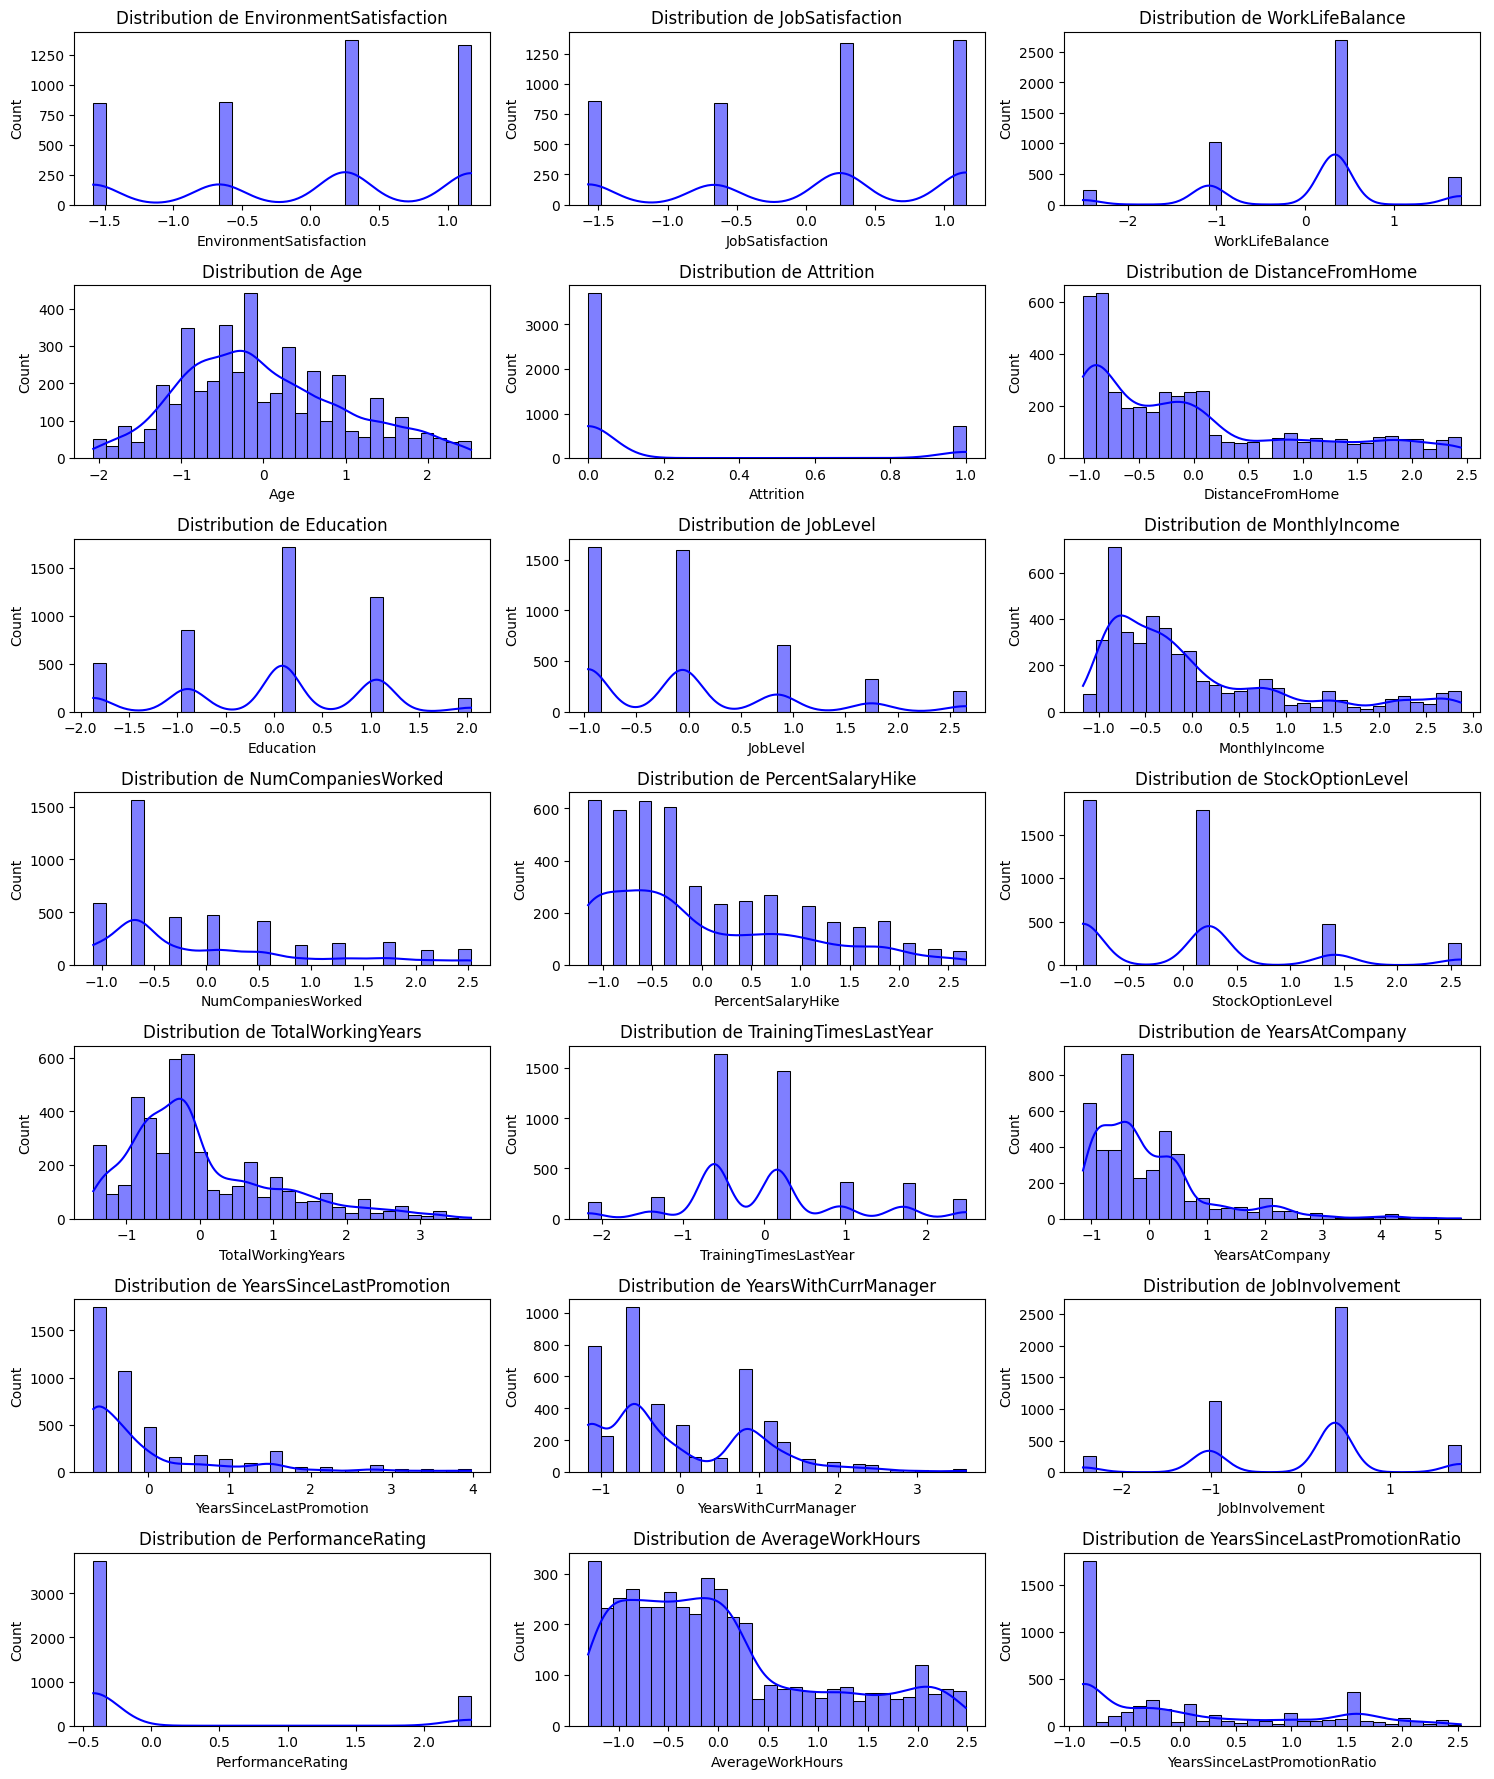

In [244]:
# Sélection des colonnes numériques
numerical_columns = df_prepared.select_dtypes(include=["number"]).columns

# Création des histogrammes
plt.figure(figsize=(15, 20))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i)
    sns.histplot(df_prepared[col], bins=30, kde=True, color="blue")
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

### 3. Matrice de Corrélation
Pour explorer les relations entre les variables numériques, nous utilisons une matrice de corrélation et une heatmap.

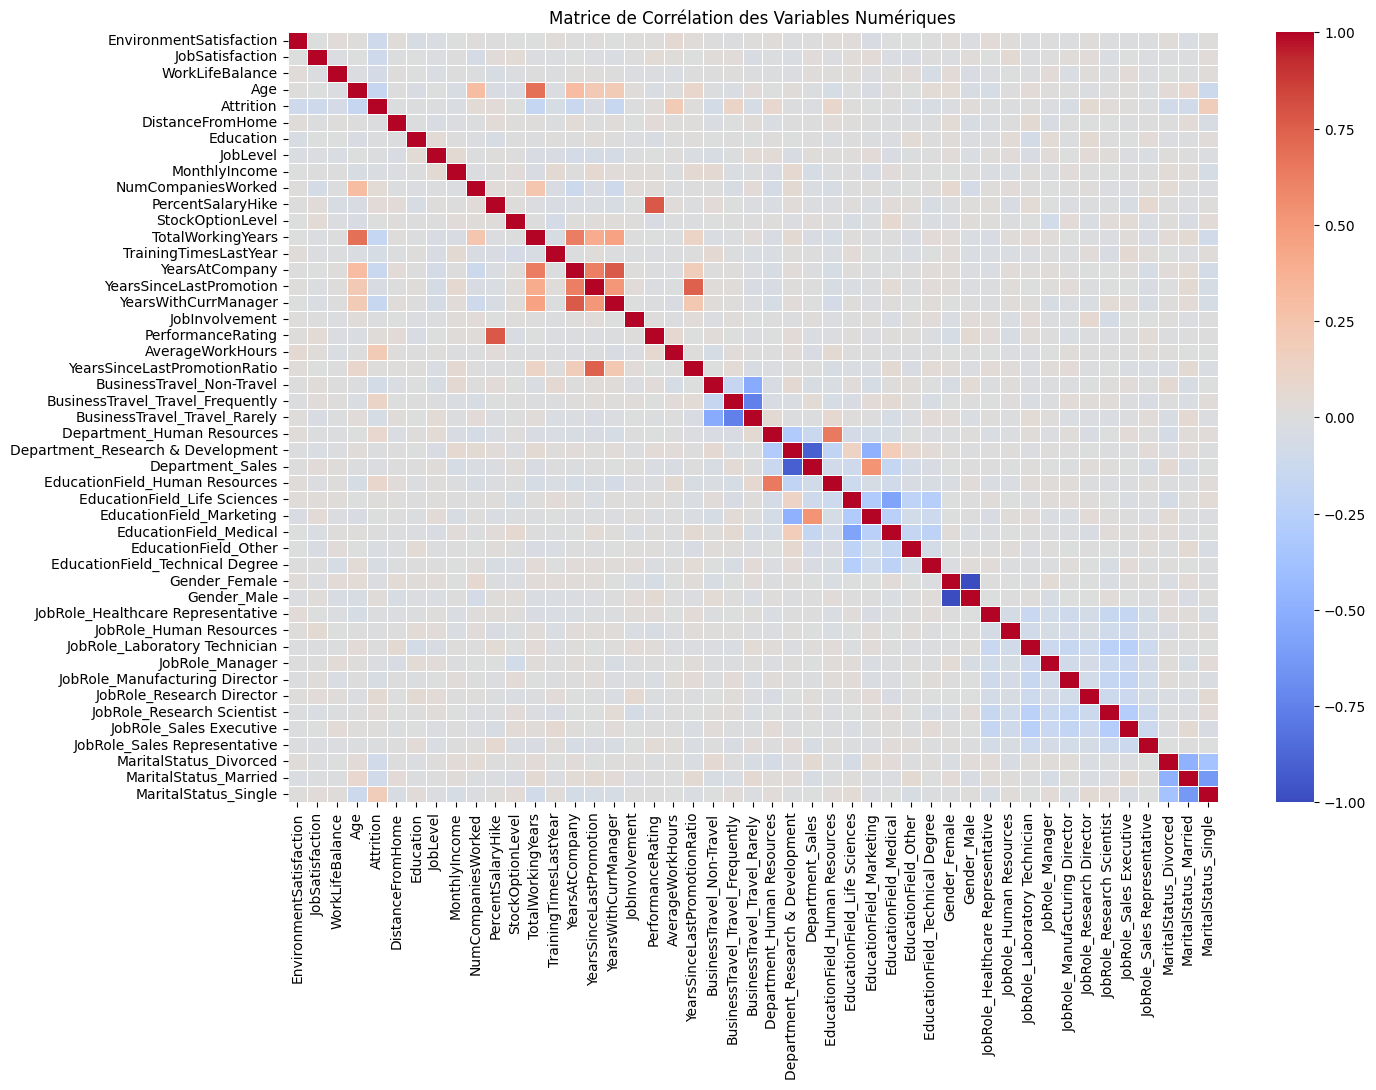

In [245]:
corr_matrix = df_prepared.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

### 4. Visualisation des Relations entre les Variables
Nous allons créer quelques graphes de dispersion pour visualiser les relations entre certaines variables clés.

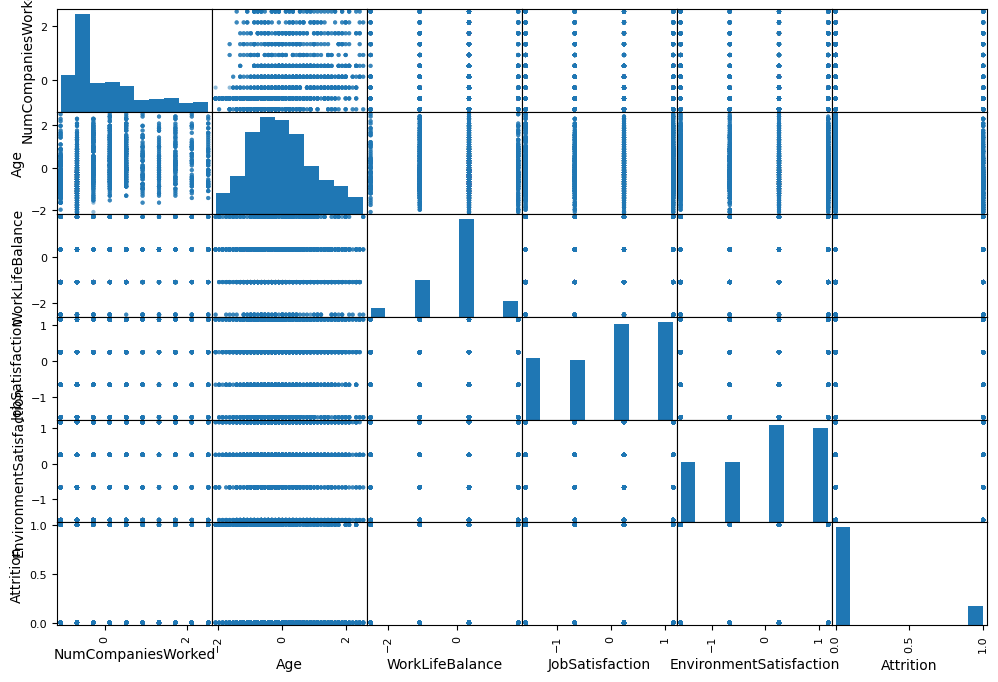

In [184]:
attributes = ["NumCompaniesWorked", "Age", "WorkLifeBalance", "JobSatisfaction", "EnvironmentSatisfaction", "Attrition"]
scatter_matrix = pd.plotting.scatter_matrix(df_prepared[attributes], figsize=(12, 8))
plt.show()

### 5. Analyse de la Variable Cible
Analysons la variable cible Attrition pour voir comment elle est distribuée.

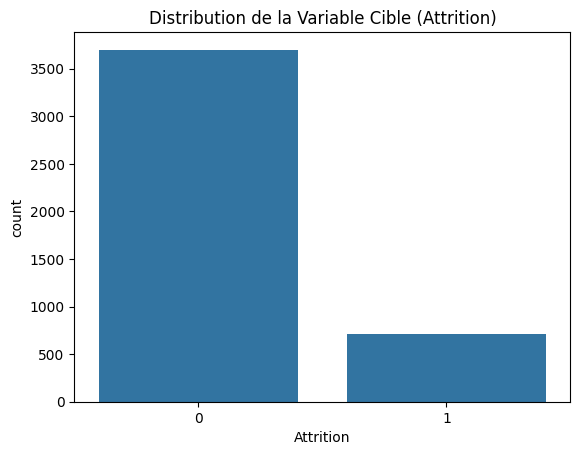

In [185]:
sns.countplot(x='Attrition', data=df_prepared)
plt.title('Distribution de la Variable Cible (Attrition)')
plt.show()

interpretation chatgpt

### 6. Relations entre les Variables et la Cible (à completer)
Examinons comment certaines variables influencent la probabilité de vendre un bien immobilier dans les 6 mois.

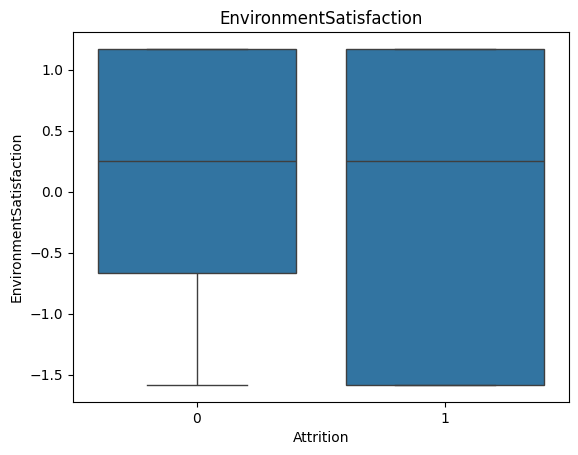

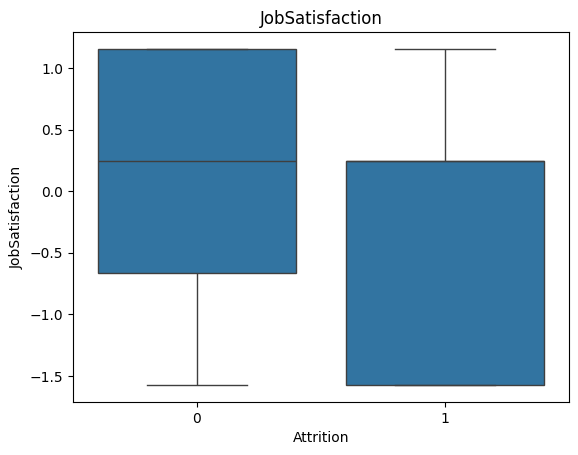

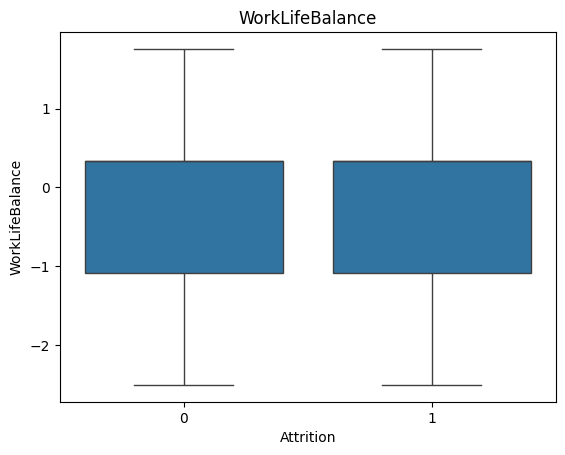

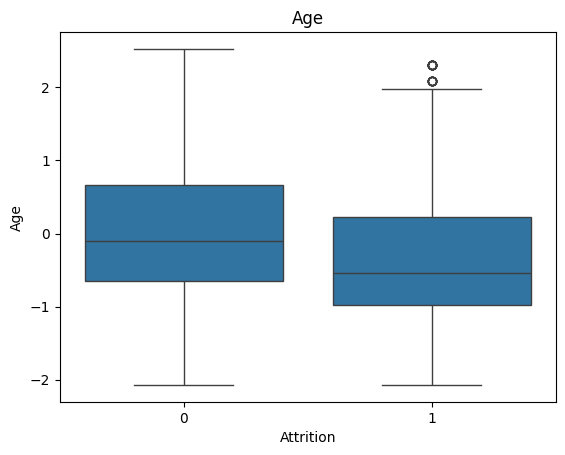

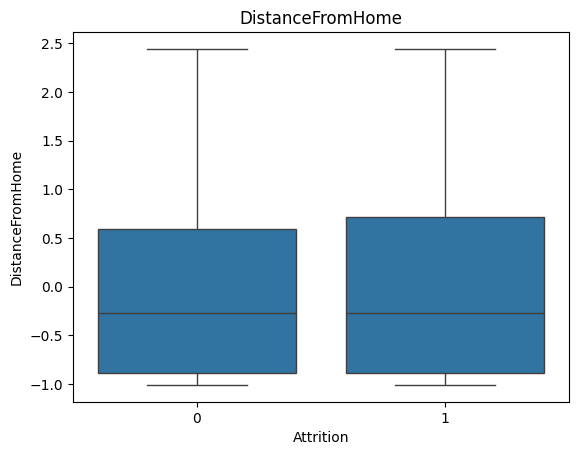

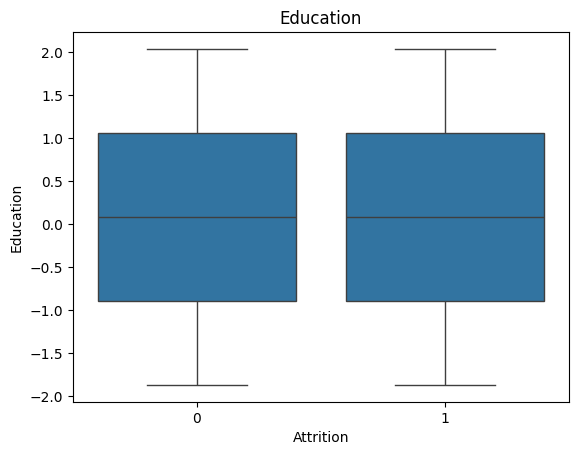

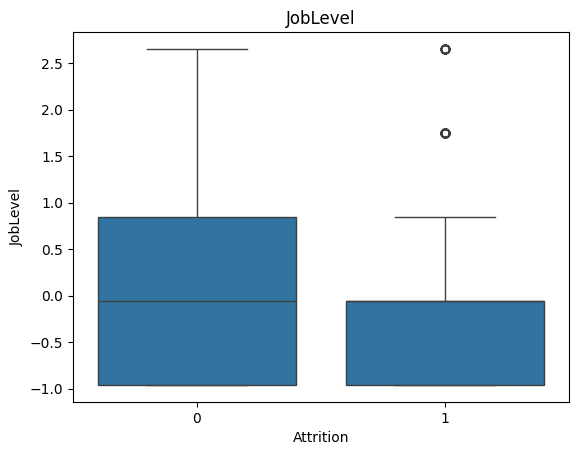

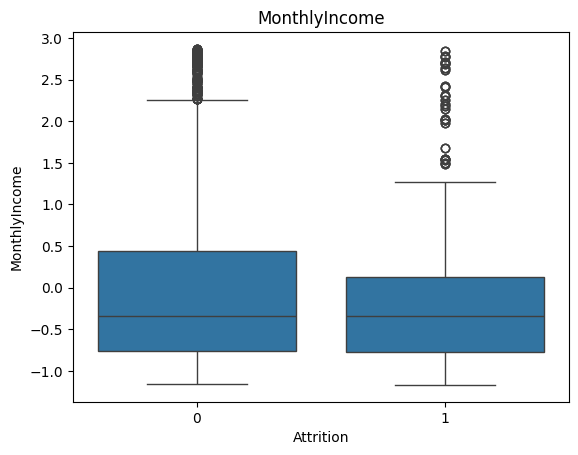

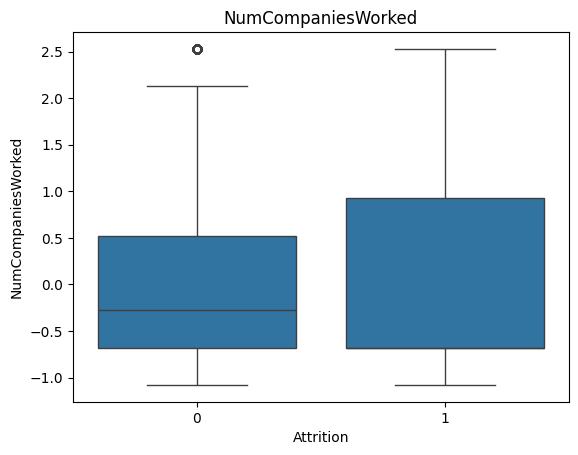

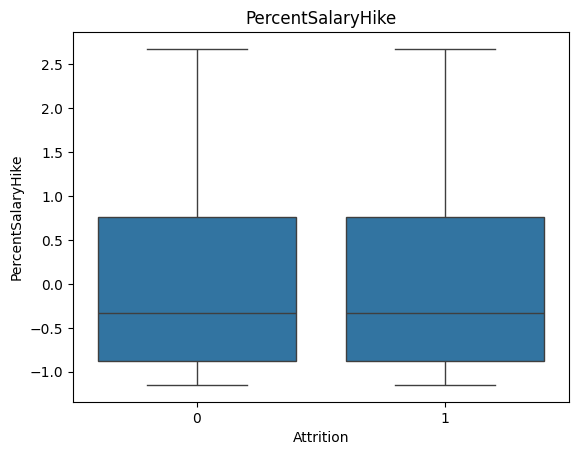

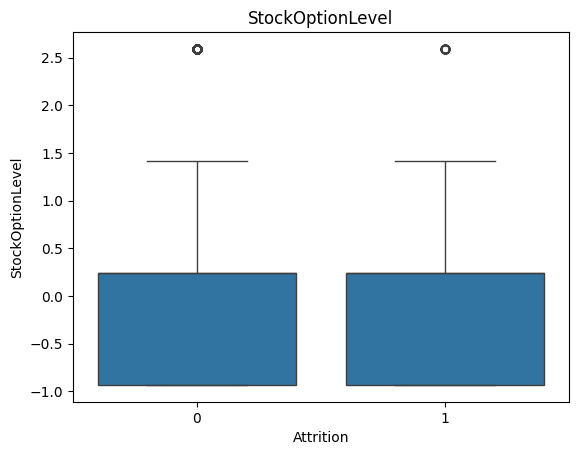

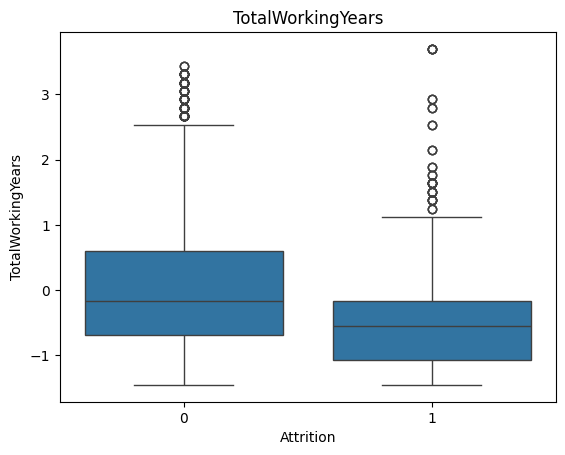

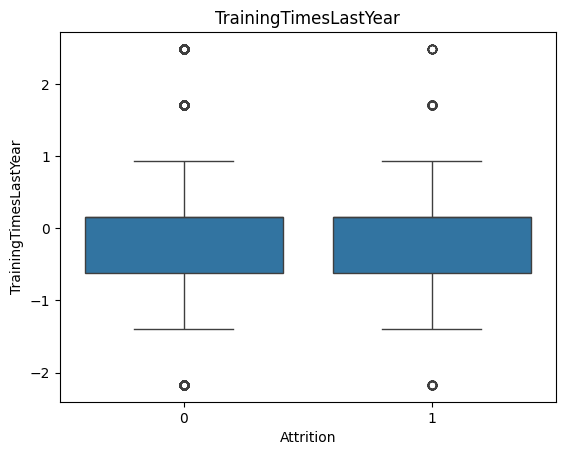

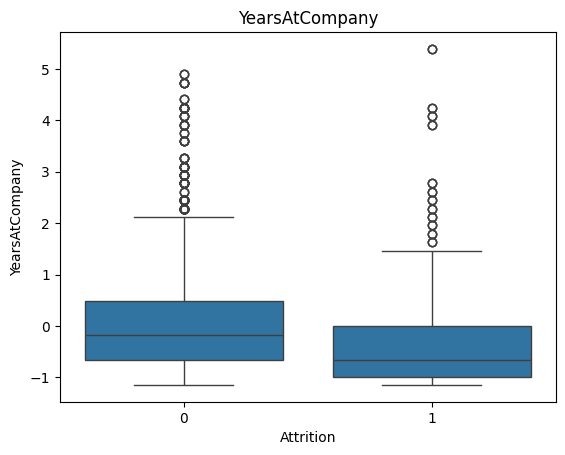

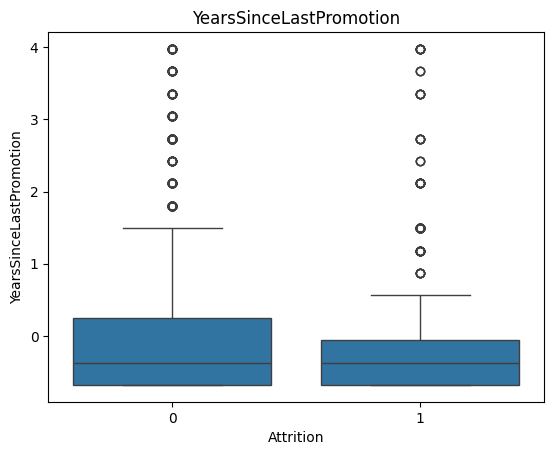

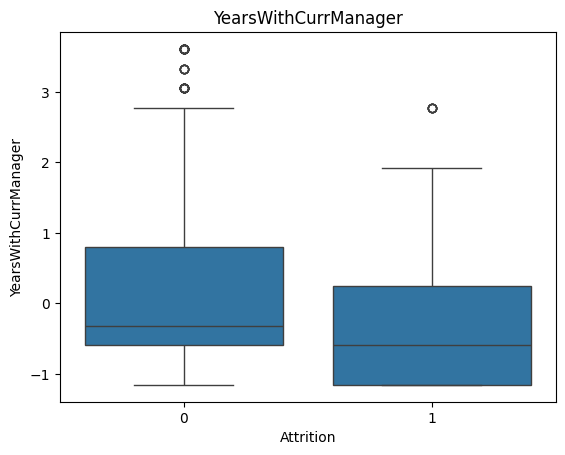

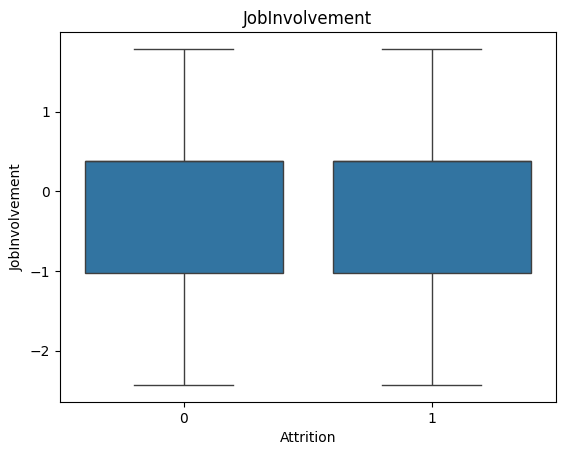

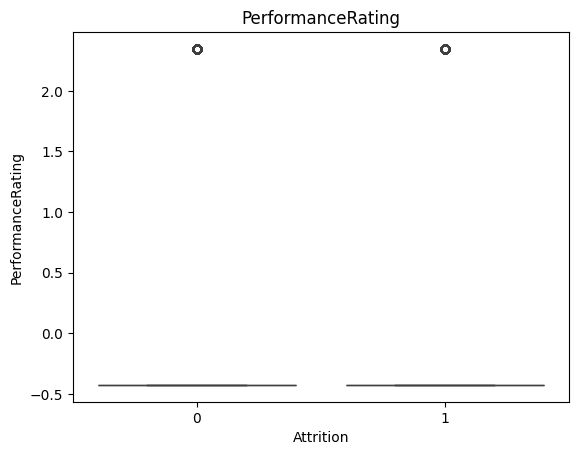

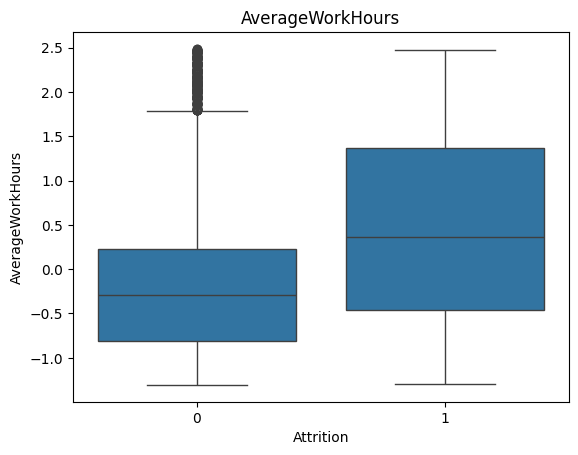

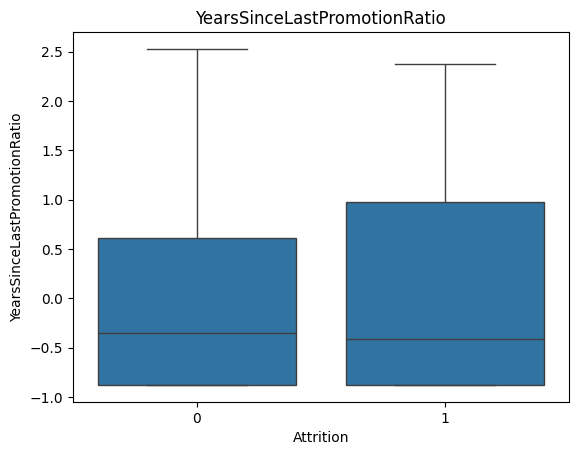

In [246]:
for columns in df_prepared.select_dtypes(np.number).columns:
    if columns == 'EmployeeID' or columns == 'Attrition':
        continue
    sns.boxplot(x='Attrition', y=columns, data=df_prepared)
    plt.title(columns)
    plt.show()

## Modèles de Classification
Dans cette section, nous allons créer et évaluer plusieurs modèles de classification afin de prédire...

CHATGPT (ici on met des definitions rapide et insights sur les modeles CHOIX DES MODELES A TESTER (interpretabilité vs performance...))

### Rappel des Principales Métriques de Performance

Les métriques de performance sont essentielles pour évaluer l'efficacité des modèles de classification. Voici un rappel des principales métriques utilisées :

#### 1. Précision (Accuracy)
La précision est le ratio du nombre de prédictions correctes sur le nombre total de prédictions.

$
\text{Précision} = \frac{\text{Nombre de prédictions correctes}}{\text{Nombre total de prédictions}}
$

#### 2. Précision (Precision)
La précision est le ratio des vraies positives (VP) sur la somme des vraies positives (VP) et des fausses positives (FP).

$
\text{Précision} = \frac{VP}{VP + FP}
$

#### 3. Rappel (Recall)
Le rappel est le ratio des vraies positives (VP) sur la somme des vraies positives (VP) et des fausses négatives (FN).

$
\text{Rappel} = \frac{VP}{VP + FN}
$

#### 4. F1-Score
Le F1-score est la moyenne harmonique de la précision et du rappel, offrant un équilibre entre les deux.

$
\text{F1-Score} = 2 \times \frac{\text{Précision} \times \text{Rappel}}{\text{Précision} + \text{Rappel}}
$

### Matrice de Confusion

La matrice de confusion est une méthode de visualisation de la performance d'un modèle de classification. Elle affiche les résultats sous forme de tableau, avec les prédictions réelles et prédites. Ses composants sont :

- **Vraies Positives (VP)** : Nombre de fois où la classe positive a été correctement prédite.
- **Fausses Positives (FP)** : Nombre de fois où la classe négative a été incorrectement prédite comme positive.
- **Vraies Négatives (VN)** : Nombre de fois où la classe négative a été correctement prédite.
- **Fausses Négatives (FN)** : Nombre de fois où la classe positive a été incorrectement prédite comme négative.

$
\begin{array}{|c|c|c|}
\hline
& \text{Prédite Positive} & \text{Prédite Négative} \\
\hline
\text{Réelle Positive} & \text{VP} & \text{FN} \\
\hline
\text{Réelle Négative} & \text{FP} & \text{VN} \\
\hline
\end{array}
$

### AUC et Courbe ROC

#### Courbe ROC (Receiver Operating Characteristic)

La courbe ROC est un graphique qui montre la performance d'un modèle de classification pour différents seuils de discrimination. Elle trace le taux de vrais positifs (True Positive Rate, TPR) contre le taux de faux positifs (False Positive Rate, FPR).

- **Taux de Vrais Positifs (TPR)** : C'est le rappel.

$
TPR = \frac{VP}{VP + FN}
$

- **Taux de Faux Positifs (FPR)** : C'est le ratio des fausses positives sur la somme des vraies négatives et des fausses positives.

$
FPR = \frac{FP}{FP + VN}
$

#### AUC (Area Under the Curve)

L'AUC est l'aire sous la courbe ROC. Elle mesure la capacité du modèle à distinguer entre les classes positives et négatives. Une AUC de 1.0 indique un modèle parfait, tandis qu'une AUC de 0.5 indique un modèle qui ne fait pas mieux qu'un choix aléatoire.

- **Interprétation de l'AUC** :
  - **0.9 - 1** : Excellente performance
  - **0.8 - 0.9** : Bonne performance
  - **0.7 - 0.8** : Acceptable
  - **0.6 - 0.7** : Faible performance
  - **0.5 - 0.6** : Très faible performance

Les courbes ROC et les scores AUC sont des outils précieux pour comparer les performances de différents modèles de classification, en particulier dans des situations où les classes sont déséquilibrées.

En utilisant ces métriques et outils, vous pouvez évaluer de manière exhaustive la performance de vos modèles de classification et choisir celui qui est le mieux adapté à votre problème.


## Application des modèles
### 0. Préparation des données d'apprentissage et de test

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [188]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1323 entries, 3662 to 4
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EnvironmentSatisfaction            1323 non-null   float64
 1   JobSatisfaction                    1323 non-null   float64
 2   WorkLifeBalance                    1323 non-null   float64
 3   Age                                1323 non-null   float64
 4   DistanceFromHome                   1323 non-null   float64
 5   Education                          1323 non-null   float64
 6   JobLevel                           1323 non-null   float64
 7   MonthlyIncome                      1323 non-null   float64
 8   NumCompaniesWorked                 1323 non-null   float64
 9   PercentSalaryHike                  1323 non-null   float64
 10  StockOptionLevel                   1323 non-null   float64
 11  TotalWorkingYears                  1323 non-null   float64
 1

### 1. Régression Logistique

La régression logistique est une technique statistique utilisée pour modéliser la probabilité qu'un événement binaire (avec deux issues possibles) se produise. Contrairement à la régression linéaire, qui prédit une valeur continue, la régression logistique prédit la probabilité d'une occurrence d'un événement.

#### Formulation Mathématique

La régression logistique utilise la fonction logistique ou sigmoïde pour transformer la sortie de la régression linéaire en une probabilité.

La fonction logistique est définie comme suit :
$\sigma(z) = \frac{1}{1 + e^{-z}}$

En régression logistique, \( z \) est une combinaison linéaire des caractéristiques :
$z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$

Où :
- $\beta_0$ est l'ordonnée à l'origine (intercept)
- $\beta_1, \beta_2, \ldots, \beta_n$ sont les coefficients des caractéristiques $x_1, x_2, \ldots, x_n $

La probabilité que l'événement se produise (par exemple, \( y = 1 \)) est alors donnée par :
$P(y=1|x) = \sigma(z) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n)}}$

#### Fonction de Coût

La fonction de coût utilisée pour ajuster les paramètres de la régression logistique est la log-vraisemblance, définie comme suit :
$J(\beta) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)}) \right] $

Où :
- $m$ est le nombre d'échantillons
- $y^{(i)}$ est la valeur réelle pour l'échantillon $i$
- $\hat{y}^{(i)}$ est la probabilité prédite pour l'échantillon $i$

#### Entraînement du Modèle

L'entraînement du modèle de régression logistique consiste à trouver les paramètres $\beta$ qui minimisent la fonction de coût. Ceci est généralement fait à l'aide de l'algorithme de descente de gradient.

Matrice de Confusion (Régression Logistique) :
 [[1078   32]
 [ 158   55]]
Rapport de Classification (Régression Logistique) :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.63      0.26      0.37       213

    accuracy                           0.86      1323
   macro avg       0.75      0.61      0.64      1323
weighted avg       0.83      0.86      0.83      1323

AUC-ROC (Régression Logistique) :
 0.6146935668062429


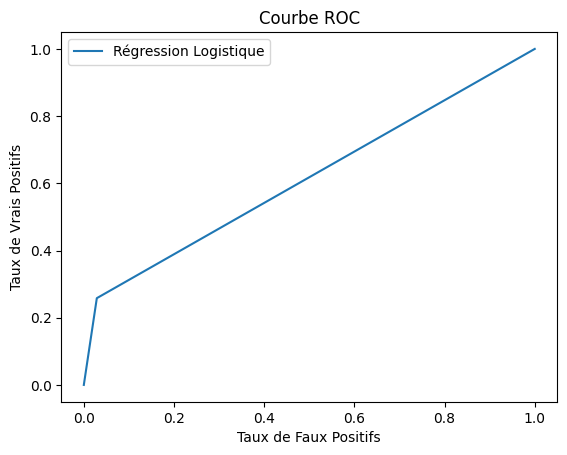

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Initialisation et entraînement du modèle
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

# Prédictions
y_pred_log_reg = log_reg.predict(X_test)

# Matrice de confusion
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Matrice de Confusion (Régression Logistique) :\n", conf_matrix_log_reg)

# Rapport de classification
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Rapport de Classification (Régression Logistique) :\n", class_report_log_reg)

# AUC-ROC
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print("AUC-ROC (Régression Logistique) :\n", roc_auc_log_reg)

# Courbe ROC
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_pred_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label="Régression Logistique")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

Interpretation : (performance moyen)  besoin d'optimisation des hyperparametres (grid search)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Matrice de Confusion (Régression Logistique) :
 [[839 271]
 [ 55 158]]
Rapport de Classification (Régression Logistique) :
               precision    recall  f1-score   support

           0       0.94      0.76      0.84      1110
           1       0.37      0.74      0.49       213

    accuracy                           0.75      1323
   macro avg       0.65      0.75      0.66      1323
weighted avg       0.85      0.75      0.78      1323

AUC-ROC (Régression Logistique) :
 0.7488199467072707


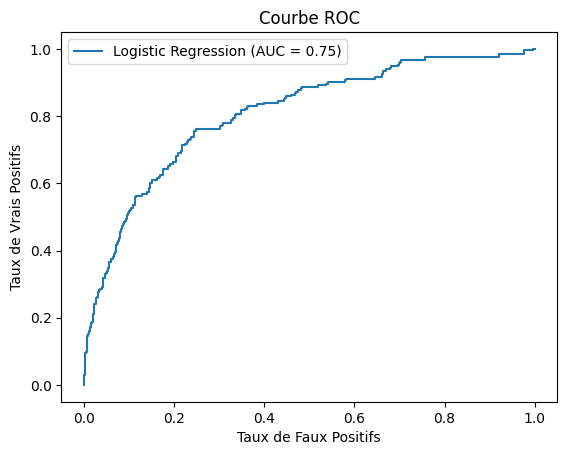

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'penalty': ['l1', 'l2'],                # Regularization type
    'solver': ['liblinear', 'saga'],        # Optimization algorithm
    'class_weight': [None, 'balanced']      # Handle class imbalance
}

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=500)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and score
print("Best Parameters:", grid_search.best_params_)
#print("Best AUC-ROC Score from GridSearchCV:", grid_search.best_score_)

# Use the best model from Grid Search
best_log_reg = grid_search.best_estimator_

# Make predictions
y_pred_log_reg = best_log_reg.predict(X_test)

# Evaluate the model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)

print("Matrice de Confusion (Régression Logistique) :\n", conf_matrix_log_reg)
print("Rapport de Classification (Régression Logistique) :\n", class_report_log_reg)
print("AUC-ROC (Régression Logistique) :\n", roc_auc_log_reg)

# Plot ROC Curve
y_proba_log_reg = best_log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_proba_log_reg)

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.2f})")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### 2. Random Forest

Les forêts aléatoires sont une méthode d'ensemble puissante et flexible utilisée pour les tâches de classification et de régression. Elles combinent plusieurs arbres de décision pour améliorer les performances prédictives et réduire les risques de surapprentissage.

#### Principe de Fonctionnement

Une forêt aléatoire est constituée de nombreux arbres de décision indépendants, chacun construit sur un échantillon aléatoire des données d'entraînement et utilisant un sous-ensemble aléatoire des caractéristiques pour chaque division de l'arbre. Les prédictions de tous les arbres sont ensuite combinées pour produire une seule prédiction finale.

#### Construction de la Forêt Aléatoire

1. **Échantillonnage Bootstrap** : Pour chaque arbre de la forêt, un échantillon aléatoire avec remplacement (bootstrap) des données d'entraînement est créé. Cela signifie que certains exemples peuvent être sélectionnés plusieurs fois, tandis que d'autres peuvent ne pas être sélectionnés du tout.
2. **Sélection de Sous-ensembles de Caractéristiques** : À chaque nœud de chaque arbre, un sous-ensemble aléatoire des caractéristiques est sélectionné. L'arbre choisit la meilleure division parmi ce sous-ensemble de caractéristiques.
3. **Construction des Arbres** : Les arbres de décision sont construits jusqu'à leur complétion sans élagage. Cela permet à chaque arbre de capturer des modèles complexes dans les données.
4. **Agrégation des Prédictions** : Pour la classification, chaque arbre vote pour une classe, et la classe avec le plus de votes est choisie comme prédiction finale (majority voting). Pour la régression, la moyenne des prédictions de tous les arbres est utilisée.

#### Avantages et Inconvénients

##### Avantages :
- **Réduction du Surapprentissage** : En combinant les prédictions de plusieurs arbres, les forêts aléatoires réduisent le risque de surapprentissage par rapport aux arbres de décision individuels.
- **Robustesse** : Insensibles aux variations dans les données d'entraînement. Les forêts aléatoires sont moins sensibles aux fluctuations dans les données d'entraînement.
- **Gestion des Caractéristiques** : Capables de gérer un grand nombre de caractéristiques et de déterminer les plus importantes.
- **Manipulation des Données Manquantes** : Peuvent gérer des valeurs manquantes en imputant des valeurs basées sur les arbres de la forêt.

##### Inconvénients :
- **Complexité et Temps de Calcul** : Les forêts aléatoires nécessitent plus de temps de calcul et de mémoire par rapport aux arbres de décision individuels, surtout lorsque le nombre d'arbres est élevé.
- **Interprétabilité** : Moins interprétables que les arbres de décision individuels en raison de la combinaison de nombreux arbres.

#### Applications

- **Classification** : Utilisées pour des tâches de classification dans divers domaines comme la finance, la médecine et le marketing.
- **Régression** : Prédiction de valeurs continues dans des contextes tels que la prévision des prix de l'immobilier et la prédiction des ventes.
- **Sélection de Caractéristiques** : Identification des caractéristiques les plus importantes pour la prédiction.

Les forêts aléatoires sont un outil puissant pour améliorer les performances prédictives et la robustesse des modèles de décision, en combinant la force de multiples arbres de décision tout en atténuant leurs faiblesses individuelles.

Matrice de Confusion (Random Forest) :
 [[1107    3]
 [  16  197]]
Rapport de Classification (Random Forest) :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1110
           1       0.98      0.92      0.95       213

    accuracy                           0.99      1323
   macro avg       0.99      0.96      0.97      1323
weighted avg       0.99      0.99      0.99      1323

AUC-ROC (Random Forest) :
 0.9610899632026394


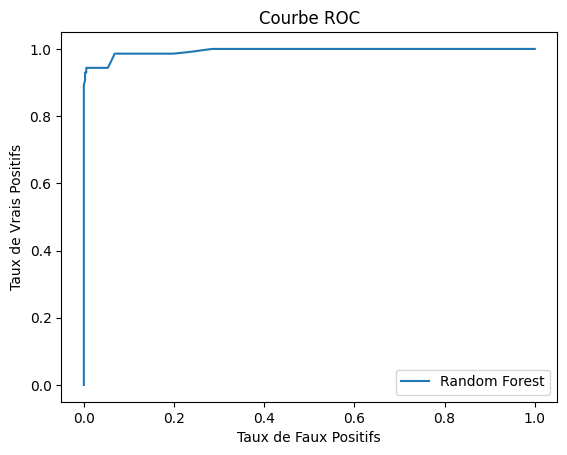

In [200]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de Confusion (Random Forest) :\n", conf_matrix_rf)

# Rapport de classification
class_report_rf = classification_report(y_test, y_pred_rf)
print("Rapport de Classification (Random Forest) :\n", class_report_rf)

# AUC-ROC
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print("AUC-ROC (Random Forest) :\n", roc_auc_rf)

# Courbe ROC
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\hamza\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC-ROC Score from GridSearchCV: 0.9844240607006565
Matrice de Confusion (Random Forest) :
 [[1110    0]
 [  15  198]]
Rapport de Classification (Random Forest) :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1110
           1       1.00      0.93      0.96       213

    accuracy                           0.99      1323
   macro avg       0.99      0.96      0.98      1323
weighted avg       0.99      0.99      0.99      1323

AUC-ROC (Random Forest) :
 0.9647887323943662


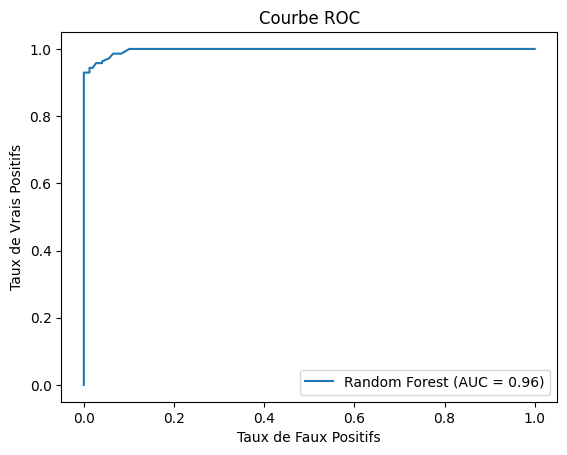

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [10, 20, 30, None],     # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],     # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],       # Minimum samples required at a leaf node
    'class_weight': [None, 'balanced']   # Handle class imbalance
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC-ROC Score from GridSearchCV:", grid_search.best_score_)

# Use the best model from Grid Search
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

print("Matrice de Confusion (Random Forest) :\n", conf_matrix_rf)
print("Rapport de Classification (Random Forest) :\n", class_report_rf)
print("AUC-ROC (Random Forest) :\n", roc_auc_rf)

# Plot ROC Curve
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]  # Predicted probabilities
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

Accuracy Scores: [0.98866213 0.99319728 0.99659864 0.99319728 0.98866213]
Mean Accuracy: 0.9921
Matrice de Confusion (K-Fold) :
 [[3699    0]
 [  35  676]]
Rapport de Classification (K-Fold) :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3699
           1       1.00      0.95      0.97       711

    accuracy                           0.99      4410
   macro avg       1.00      0.98      0.99      4410
weighted avg       0.99      0.99      0.99      4410

AUC-ROC (K-Fold) :
 0.9753867791842475


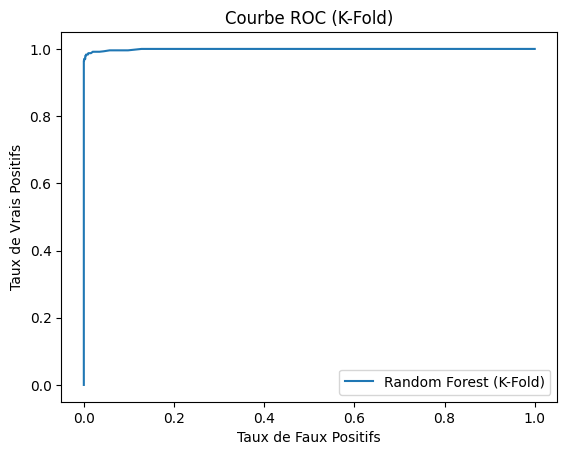

In [211]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scoring
scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy Scores: {scores}")
print(f"Mean Accuracy: {np.mean(scores):.4f}")

# Prédictions et évaluation
y_pred_kfold = cross_val_predict(rf_model, X, y, cv=kfold)
conf_matrix_kfold = confusion_matrix(y, y_pred_kfold)
class_report_kfold = classification_report(y, y_pred_kfold)
roc_auc_kfold = roc_auc_score(y, y_pred_kfold)

print("Matrice de Confusion (K-Fold) :\n", conf_matrix_kfold)
print("Rapport de Classification (K-Fold) :\n", class_report_kfold)
print("AUC-ROC (K-Fold) :\n", roc_auc_kfold)

# Courbe ROC
y_proba_kfold = cross_val_predict(rf_model, X, y, cv=kfold, method="predict_proba")[:, 1]
fpr_kfold, tpr_kfold, _ = roc_curve(y, y_proba_kfold)

plt.figure()
plt.plot(fpr_kfold, tpr_kfold, label="Random Forest (K-Fold)")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC (K-Fold)")
plt.legend()
plt.show()

Accuracy Scores: [0.98866213 0.99319728 0.99659864 0.99319728 0.98866213]
Mean Accuracy: 0.9921
Confusion Matrix (K-Fold):
 [[3699    0]
 [  35  676]]
Classification Report (K-Fold):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3699
           1       1.00      0.95      0.97       711

    accuracy                           0.99      4410
   macro avg       1.00      0.98      0.99      4410
weighted avg       0.99      0.99      0.99      4410

AUC-ROC (K-Fold):
 0.9753867791842475


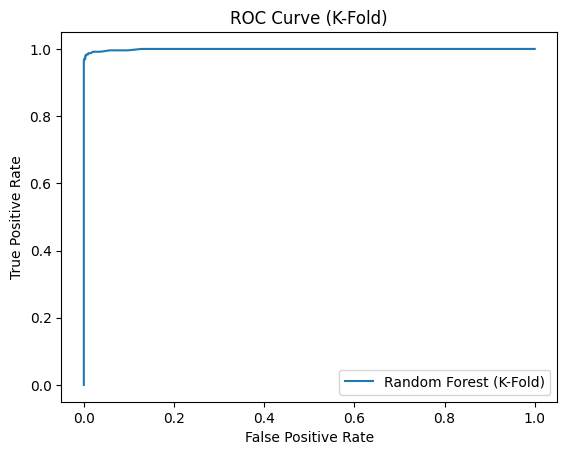

100%|===================| 8788/8820 [03:43<00:00]        

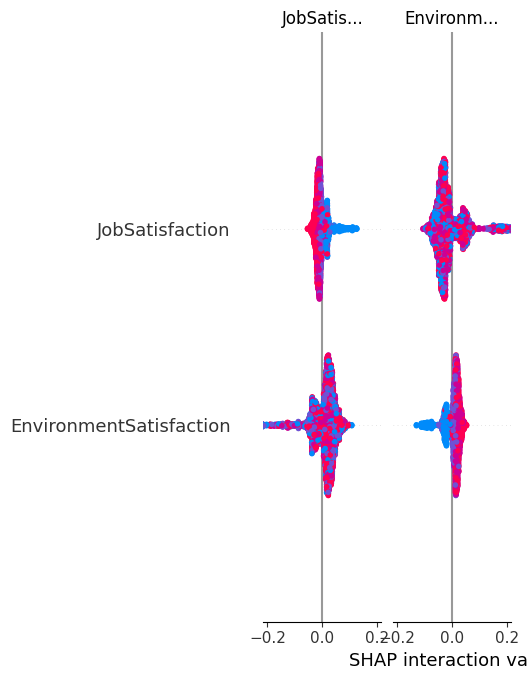

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [277]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
# Identify boolean columns
bool_cols = X.select_dtypes(include=['bool']).columns

# Convert them to integers (0 and 1)
X[bool_cols] = X[bool_cols].astype(int)

feature_names = np.array(X.columns)

import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# --- Your Existing Training Code ---
# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scoring
scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy Scores: {scores}")
print(f"Mean Accuracy: {np.mean(scores):.4f}")

# Predictions and evaluation
y_pred_kfold = cross_val_predict(rf_model, X, y, cv=kfold)
conf_matrix_kfold = confusion_matrix(y, y_pred_kfold)
class_report_kfold = classification_report(y, y_pred_kfold)
roc_auc_kfold = roc_auc_score(y, y_pred_kfold)

print("Confusion Matrix (K-Fold):\n", conf_matrix_kfold)
print("Classification Report (K-Fold):\n", class_report_kfold)
print("AUC-ROC (K-Fold):\n", roc_auc_kfold)

# ROC Curve
y_proba_kfold = cross_val_predict(rf_model, X, y, cv=kfold, method="predict_proba")[:, 1]
fpr_kfold, tpr_kfold, _ = roc_curve(y, y_proba_kfold)

plt.figure()
plt.plot(fpr_kfold, tpr_kfold, label="Random Forest (K-Fold)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (K-Fold)")
plt.legend()
plt.show()

# --- SHAP Explainability Code ---

# Fit the model on the entire dataset (needed for SHAP)
rf_model.fit(X, y)

# Use the interventional feature perturbation method and disable additivity check.
explainer = shap.Explainer(rf_model, X, feature_perturbation='interventional')

# Compute SHAP values with additivity check disabled.
shap_values = explainer(X, check_additivity=False)

# Global Explanation: Summary Plot showing feature importance
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

# Local Explanation: Force Plot for the first instance
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values.values[0, :], features=X.iloc[0, :])

# Optional: Dependence Plot for the most important feature
# Identify the most important feature (based on average absolute SHAP value)
import pandas as pd
if isinstance(X, pd.DataFrame):
    feature_importance = np.abs(shap_values.values).mean(axis=0)
    top_feature = feature_importance.argmax()
    shap.dependence_plot(top_feature, shap_values.values, X)
else:
    print("X is not a DataFrame. Please convert it to one to use feature names in plots.")

plt.show()

In [273]:
print(X.dtypes)

EnvironmentSatisfaction              float64
JobSatisfaction                      float64
WorkLifeBalance                      float64
Age                                  float64
DistanceFromHome                     float64
Education                            float64
JobLevel                             float64
MonthlyIncome                        float64
NumCompaniesWorked                   float64
PercentSalaryHike                    float64
StockOptionLevel                     float64
TotalWorkingYears                    float64
TrainingTimesLastYear                float64
YearsAtCompany                       float64
YearsSinceLastPromotion              float64
YearsWithCurrManager                 float64
JobInvolvement                       float64
PerformanceRating                    float64
AverageWorkHours                     float64
YearsSinceLastPromotionRatio         float64
BusinessTravel_Non-Travel               bool
BusinessTravel_Travel_Frequently        bool
BusinessTr

In [192]:
import shap
# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Show first 5 explanations for the first class
shap_values[0][:5]

array([[ 0.00192325, -0.00192325],
       [ 0.02370521, -0.02370521],
       [-0.0002044 ,  0.0002044 ],
       [-0.06565002,  0.06565002],
       [-0.00975828,  0.00975828]])

In [49]:
X_test.head()

EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance  \
3662                  0.25220         1.156302         1.757749   
2179                 -0.66546        -0.663899         0.336206   
110                   0.25220         0.246202         0.336206   
2473                 -0.66546         1.156302         0.336206   
3000                  0.25220        -0.663899        -1.085336   

      NumCompaniesWorked  TotalWorkingYears  AverageWorkHours_x  \
3662            1.727668          -1.064798            0.007486   
2179            0.123580          -0.550237           -1.181704   
110            -0.277442          -0.421596            1.190395   
2473            0.123580           0.478886            0.972499   
3000           -0.678464          -0.936158            2.230287   

      AverageWorkHours_y  YearsSinceLastPromotionRatio  \
3662            0.007486                     -0.878153   
2179           -1.181704                     -0.878153   
110             1.190395                     -0.347612   
2473            0.972499                      0.978741   
3000            2.230287                     -0.135396   

      Department_Human Resources  Department_Research & Development  \
3662                       False                               True   
2179                       False                               True   
110                        False                               True   
2473                       False                               True   
3000                       False                               True   

      Department_Sales  Gender_Female  Gender_Male  
3662             False           True        False  
2179             False           True        False  
110              False           True        False  
2473             False           True        False  
3000             False          False         True

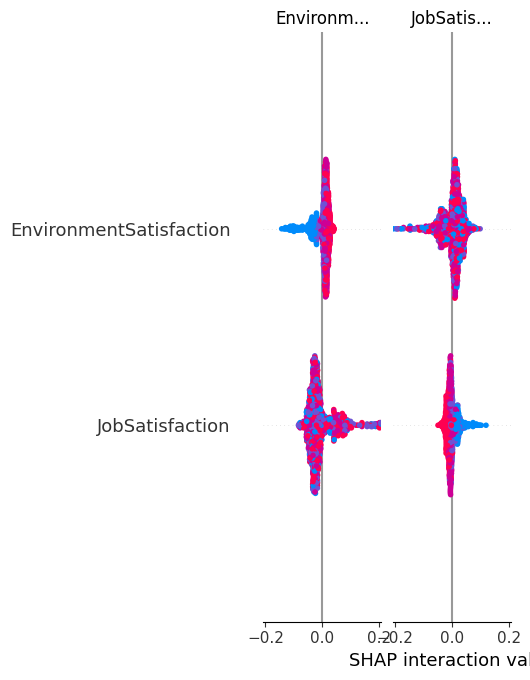

In [193]:
shap.summary_plot(shap_values, X_test)

In [201]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0])

DimensionError: Length of features is not equal to the length of shap_values!

In [195]:
shap.dependence_plot("sepal length (cm)", shap_values[0], X_test)

ValueError: Could not find feature named: sepal length (cm)

# Etude comparative entre les modèles

In [203]:
# First, install XGBoost if needed
# !pip install xgboost

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# Optional: from lightgbm import LGBMClassifier

models = {
    "Perceptron": Perceptron(),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
    # "LightGBM": LGBMClassifier(random_state=42)  # Requires !pip install lightgbm
}

# Training and prediction remains the same
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

c:\Users\hamza\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [204]:
from sklearn.metrics import confusion_matrix, classification_report

# Fonction pour afficher les résultats
def display_metrics(y_test, y_pred, model_name):
   #à Compléter
   print("Modèle: ", model_name)
   # Matrice de confusion
   conf_matrix = confusion_matrix(y_test, y_pred)
   print("Matrice de Confusion :\n", conf_matrix)

   # Rapport de classification
   class_report = classification_report(y_test, y_pred)
   
   print("\nRapport de Classification :\n", class_report)

   # AUC-ROC
   roc_auc = roc_auc_score(y_test, y_pred)
   print("AUC-ROC :\n", roc_auc)

# Calcul des métriques
for name, y_pred in predictions.items():
    #à compléter
    display_metrics(y_test, y_pred, name)

Modèle:  Perceptron
Matrice de Confusion :
 [[1013   97]
 [ 169   44]]

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1110
           1       0.31      0.21      0.25       213

    accuracy                           0.80      1323
   macro avg       0.58      0.56      0.57      1323
weighted avg       0.77      0.80      0.78      1323

AUC-ROC :
 0.5595926912828322
Modèle:  LogisticRegression
Matrice de Confusion :
 [[1078   32]
 [ 158   55]]

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.63      0.26      0.37       213

    accuracy                           0.86      1323
   macro avg       0.75      0.61      0.64      1323
weighted avg       0.83      0.86      0.83      1323

AUC-ROC :
 0.6146935668062429
Modèle:  SVM
Matrice de Confusion :
 [[1104    6]
 [ 112  101]]

Rapport de 

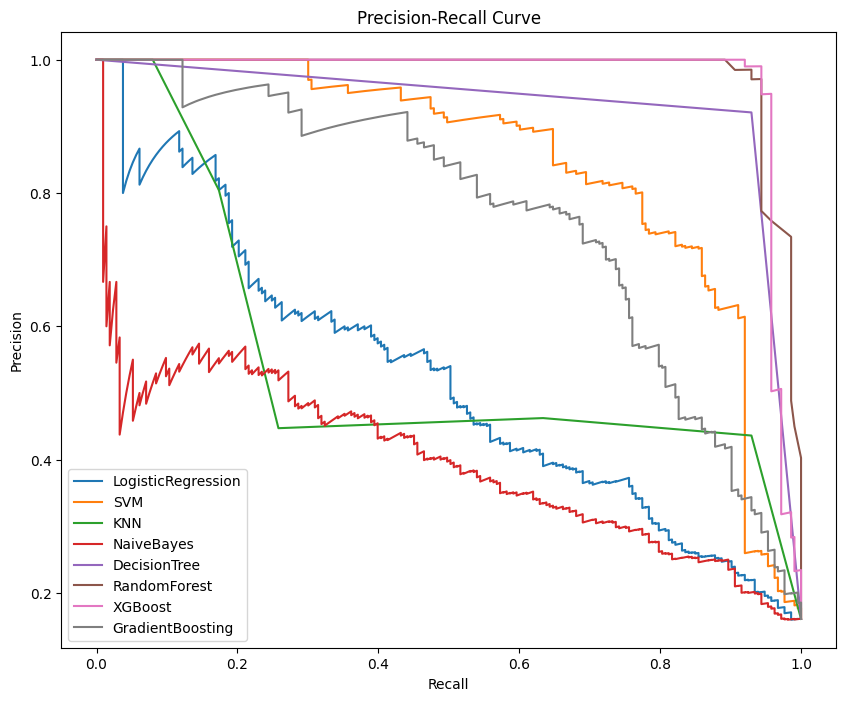

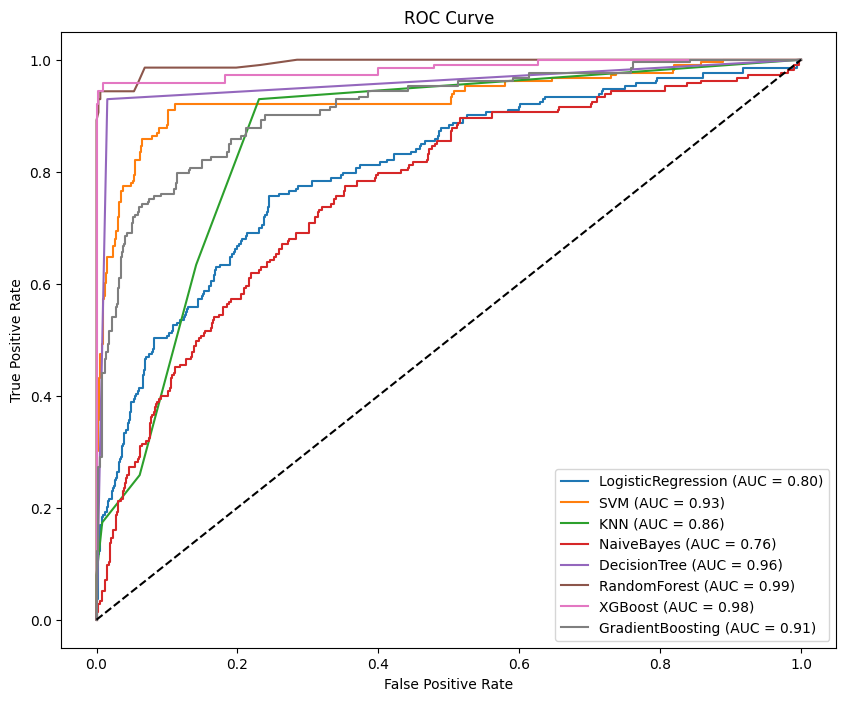

In [205]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

# Tracer les courbes de Précision-Rappel
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

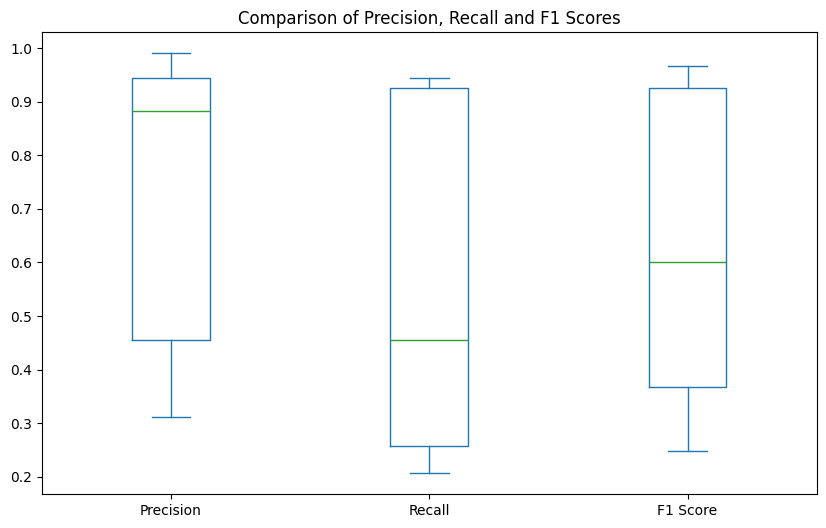

In [207]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_scores = []
recall_scores = []
f1_scores = []

for name, y_pred in predictions.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
score_df = pd.DataFrame({
    'Model': models.keys(),
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

score_df.plot(kind='box', figsize=(10, 6))
plt.title("Comparison of Precision, Recall and F1 Scores")
plt.show()

In [208]:
from sklearn.metrics import roc_auc_score

scores = []

for name, y_pred in predictions.items():
    y_proba = models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba") else None
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc_score
    })

scores_df = pd.DataFrame(scores)
print(scores_df)

                Model  Precision    Recall  F1 Score       AUC
0          Perceptron   0.312057  0.206573  0.248588       NaN
1  LogisticRegression   0.632184  0.258216  0.366667  0.804035
2                 SVM   0.943925  0.474178  0.631250  0.930910
3                 KNN   0.447154  0.258216  0.327381  0.860265
4          NaiveBayes   0.456044  0.389671  0.420253  0.764514
5        DecisionTree   0.920930  0.929577  0.925234  0.957131
6        RandomForest   0.985000  0.924883  0.953995  0.993827
7             XGBoost   0.990148  0.943662  0.966346  0.983483
8    GradientBoosting   0.881818  0.455399  0.600619  0.913082


In [243]:
import time

training_times = []
prediction_times = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_times.append(end_time-start_time)

    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    prediction_times.append(end_time-start_time)
    
time_df = pd.DataFrame({
    'Model': models.keys(),
    'Training Time (s)': training_times,
    'Prediction Time (s)': prediction_times
})
print(time_df)


c:\Users\hamza\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                Model  Training Time (s)  Prediction Time (s)
0          Perceptron           0.011691             0.002496
1  LogisticRegression           0.030866             0.001693
2                 SVM           1.413502             0.156763
3                 KNN           0.006305             0.082388
4          NaiveBayes           0.005235             0.002181
5        DecisionTree           0.034992             0.003192
6        RandomForest           0.496607             0.019148
7             XGBoost           0.184547             0.019862
8    GradientBoosting           0.965096             0.004607


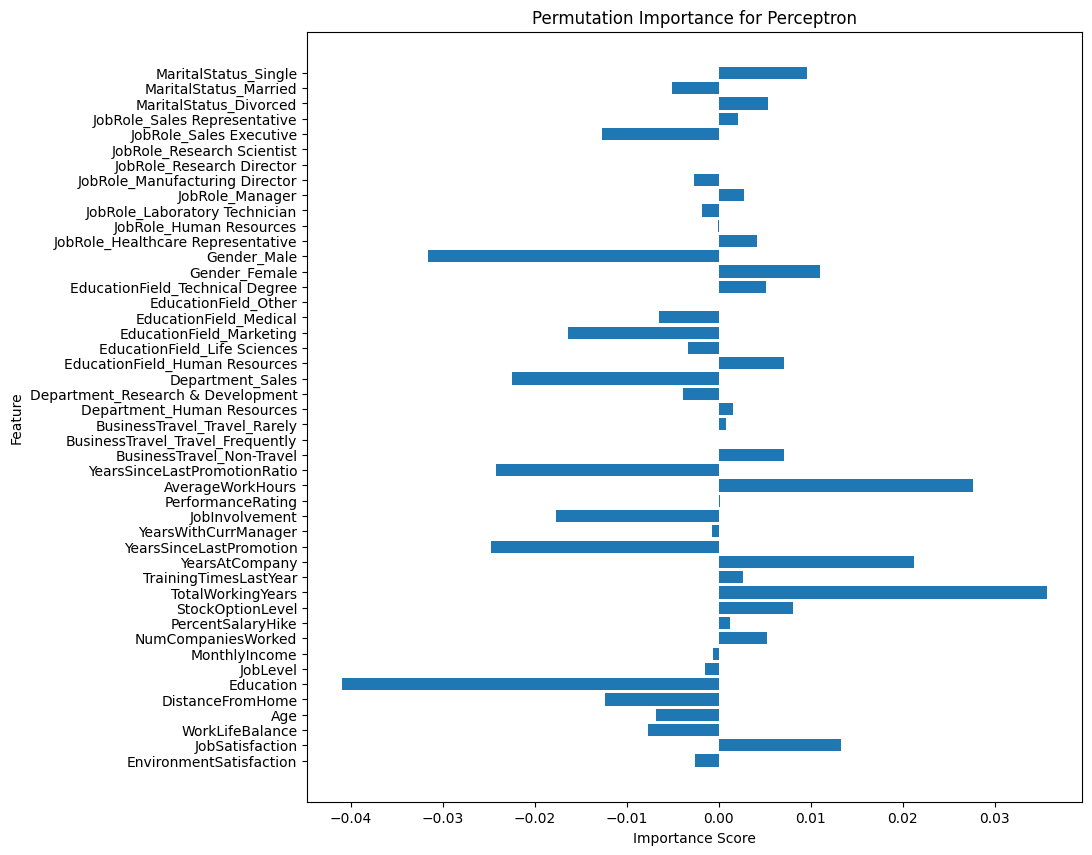

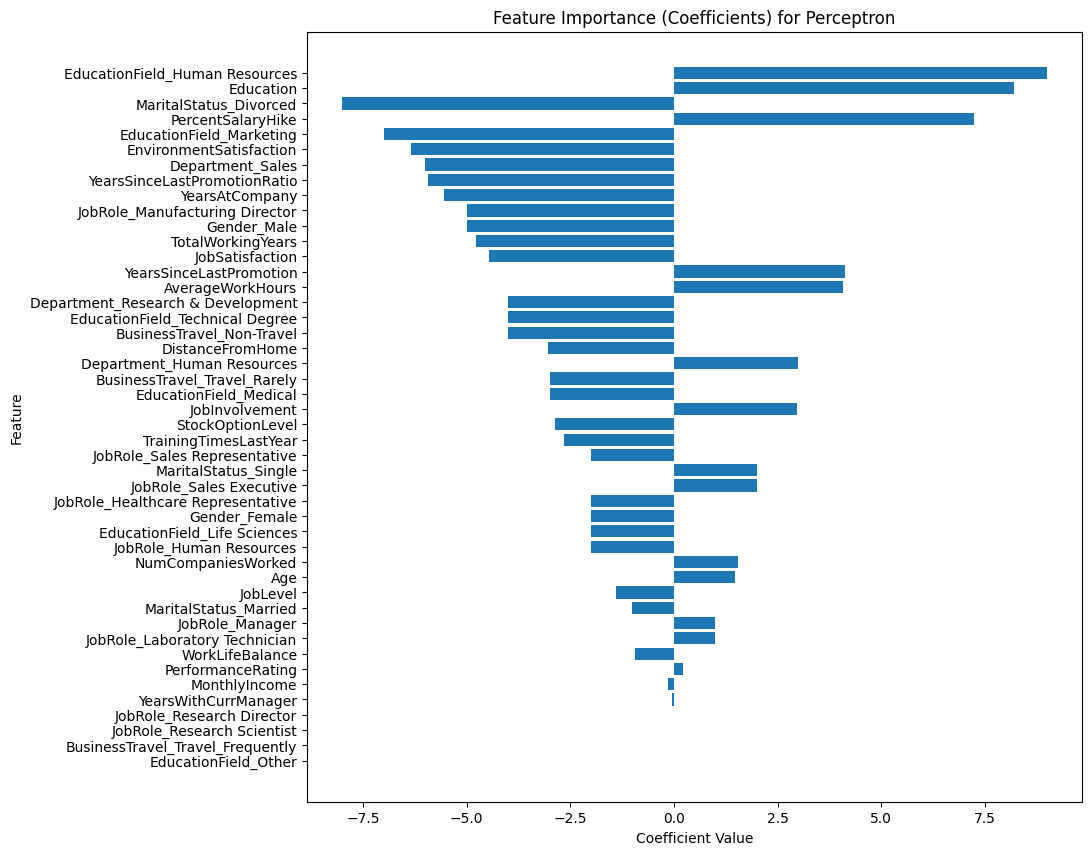

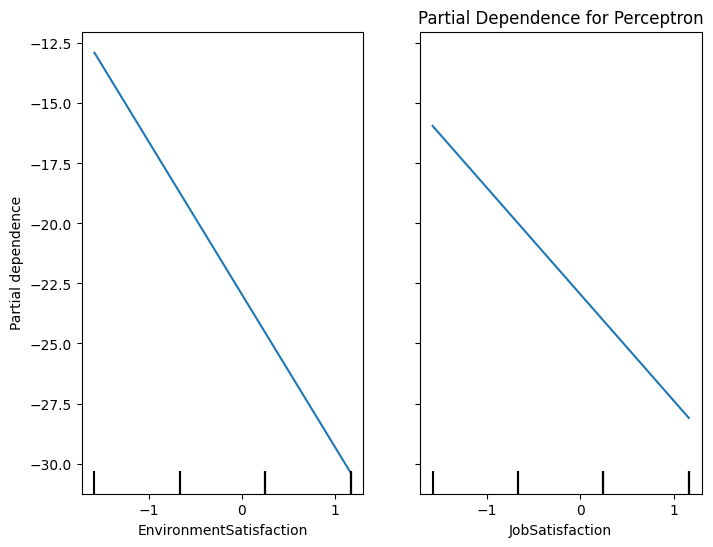

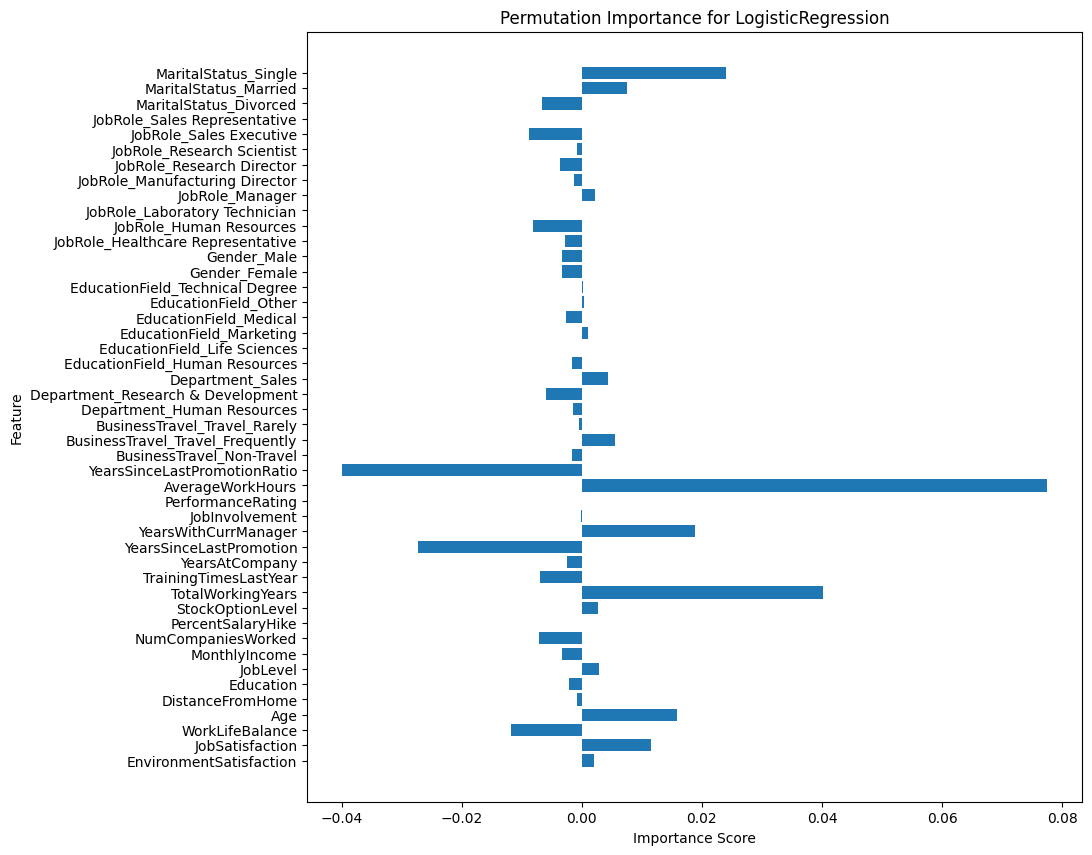

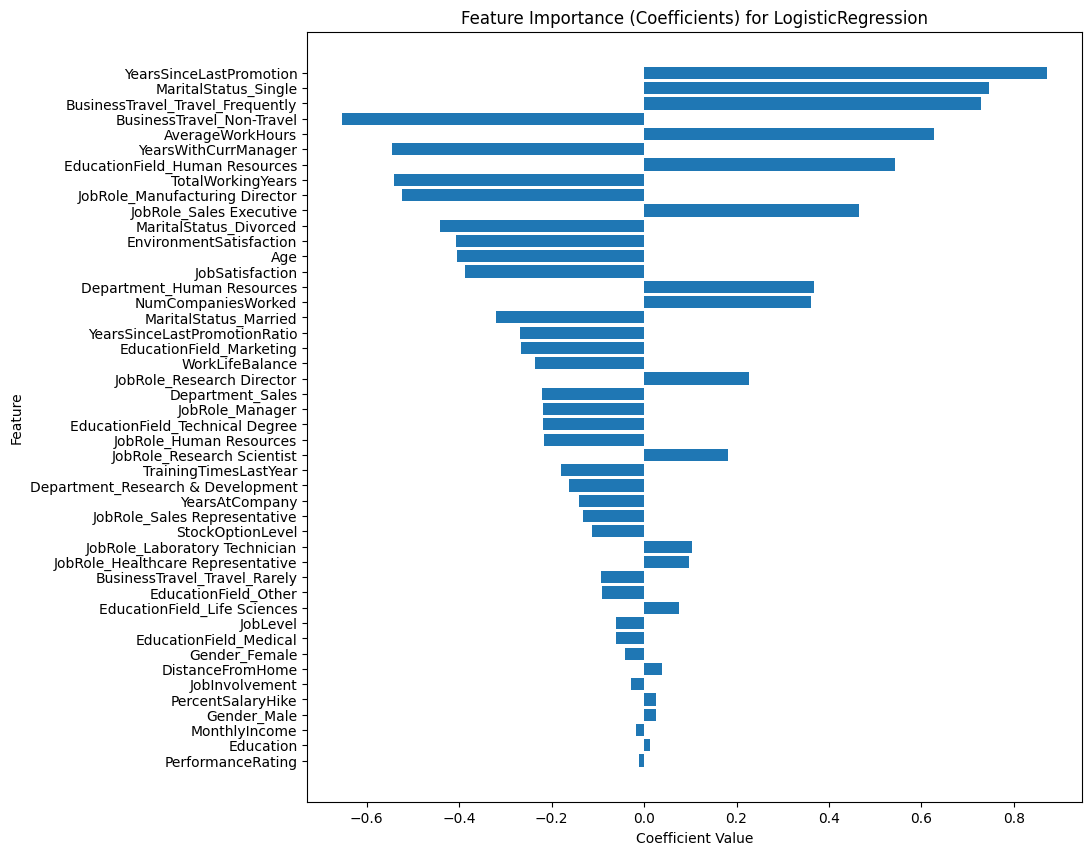

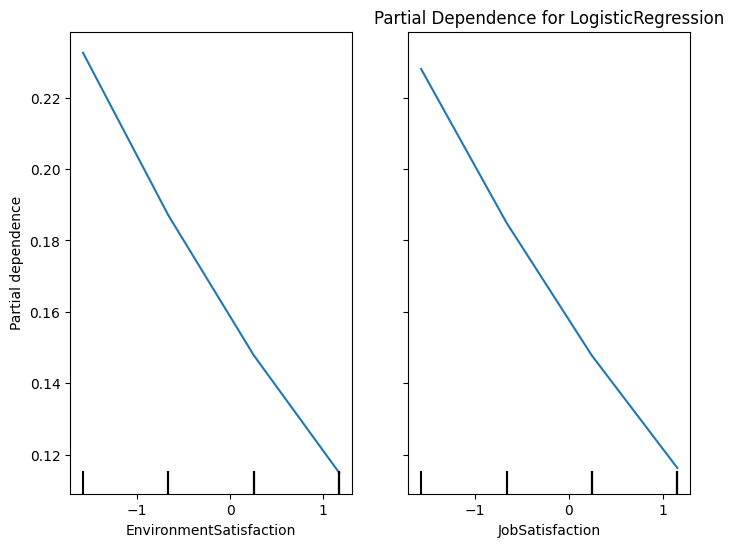

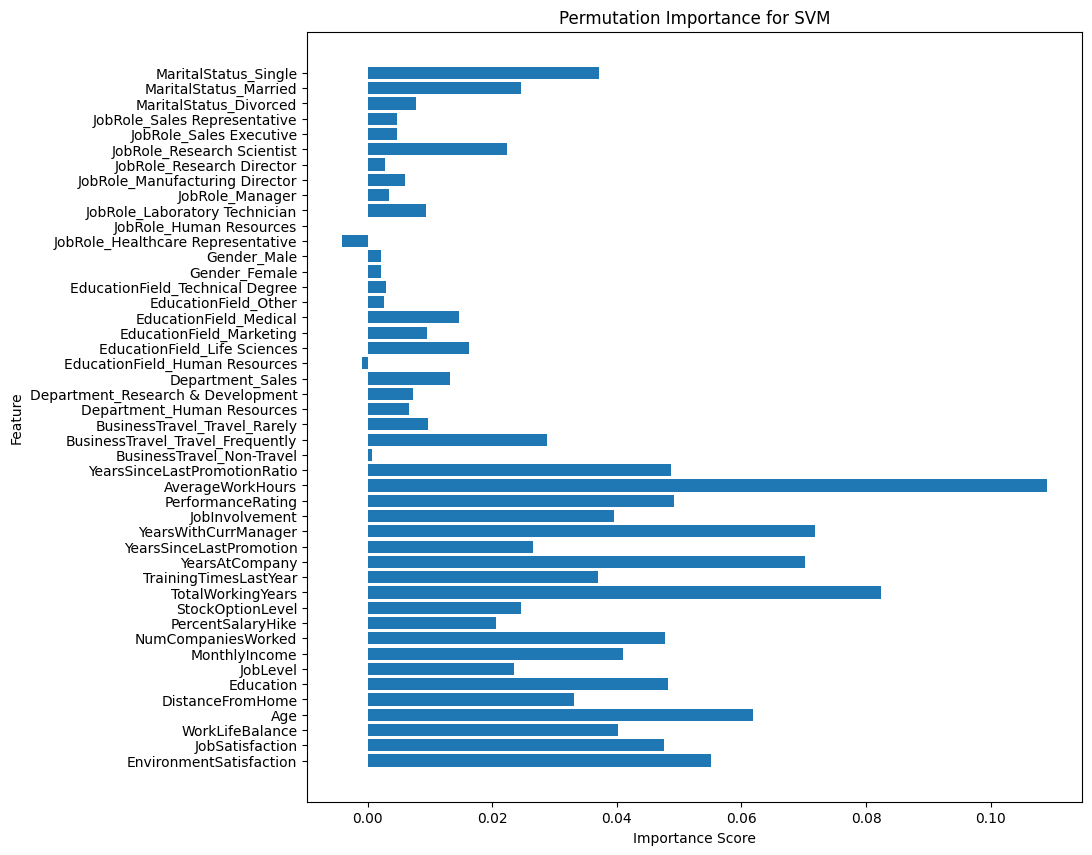

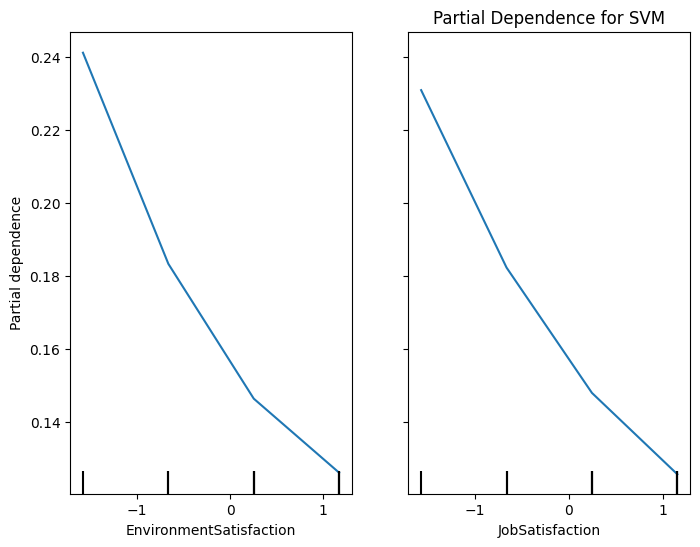

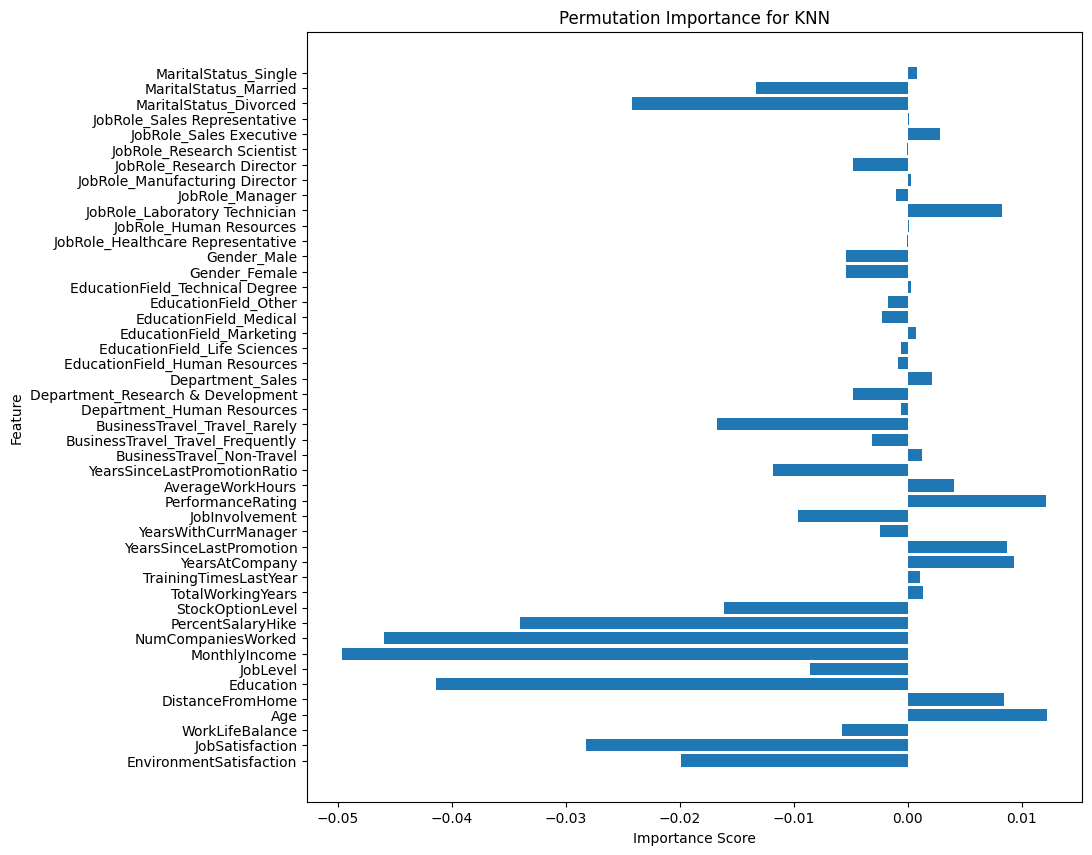

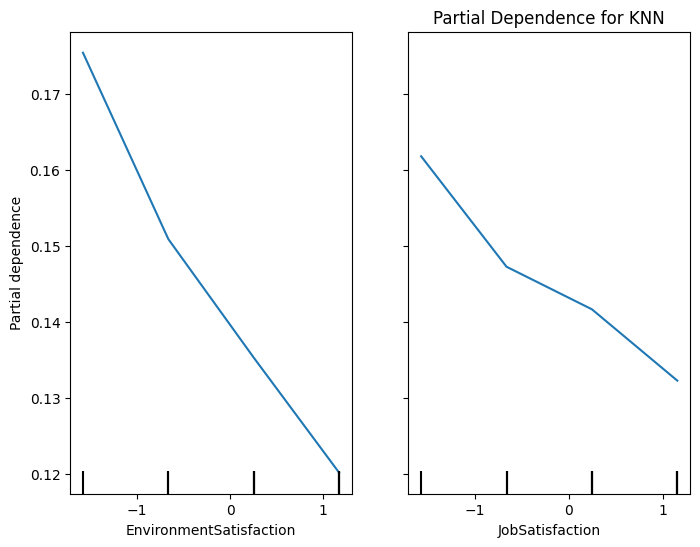

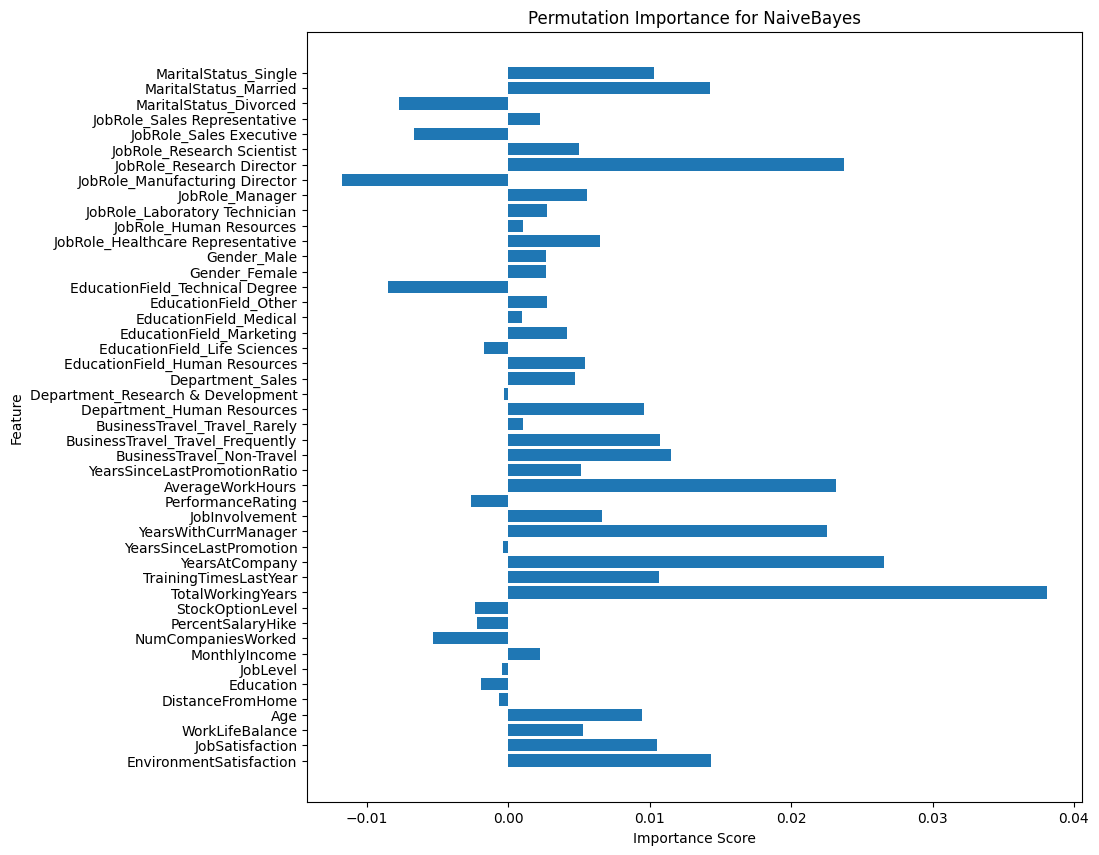

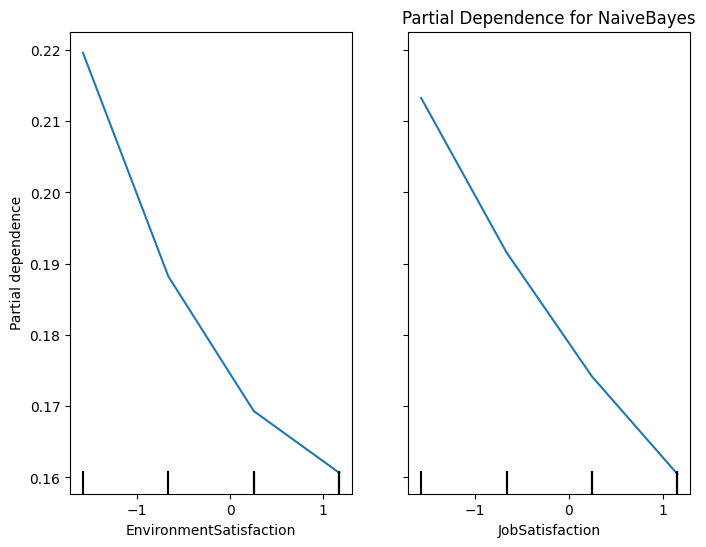

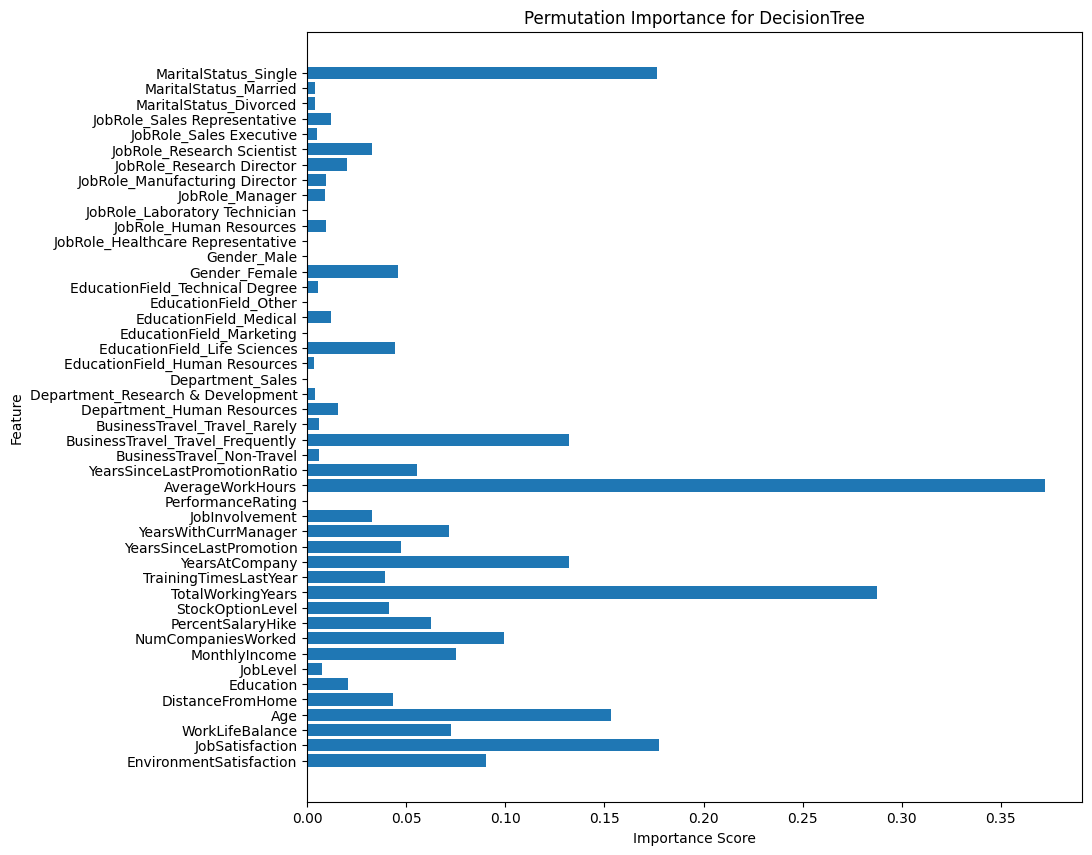

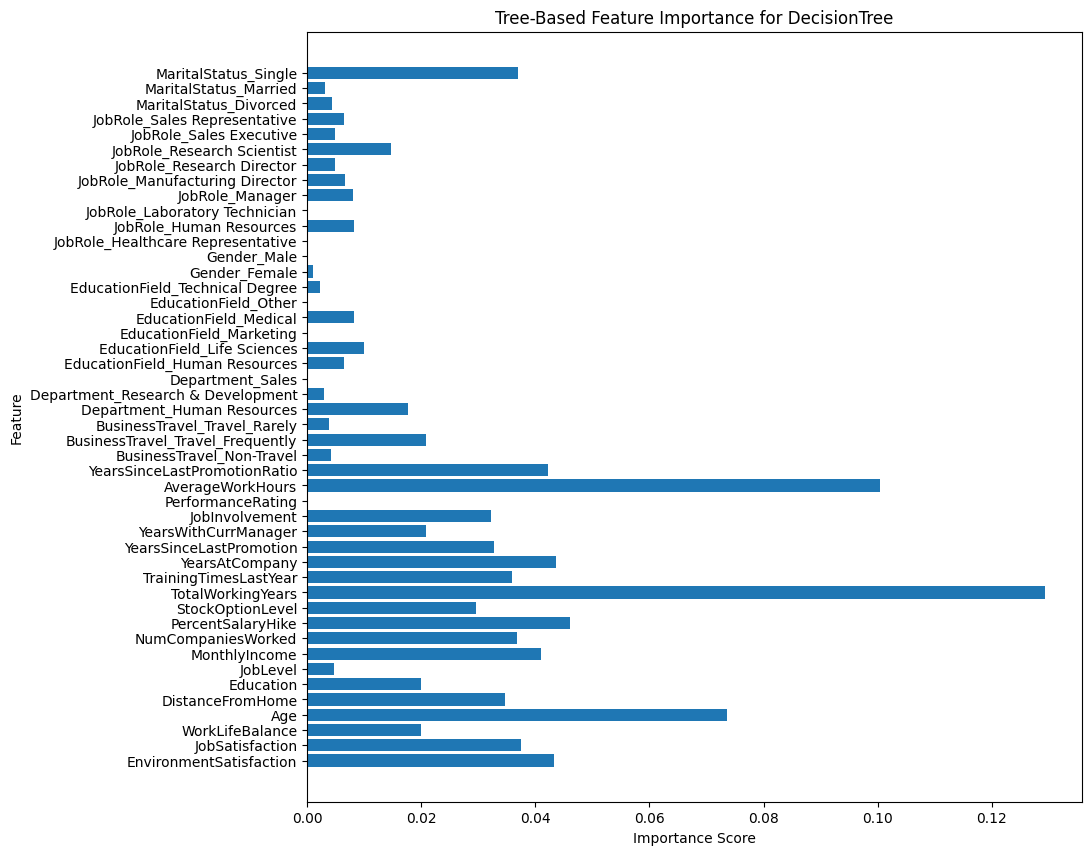

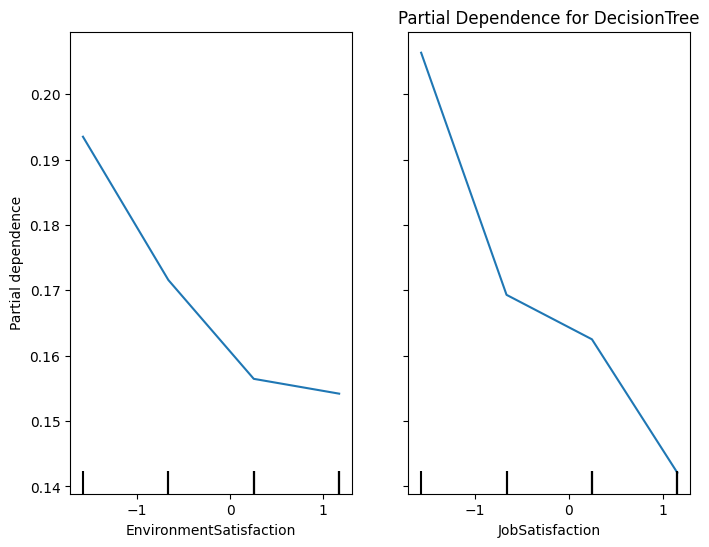

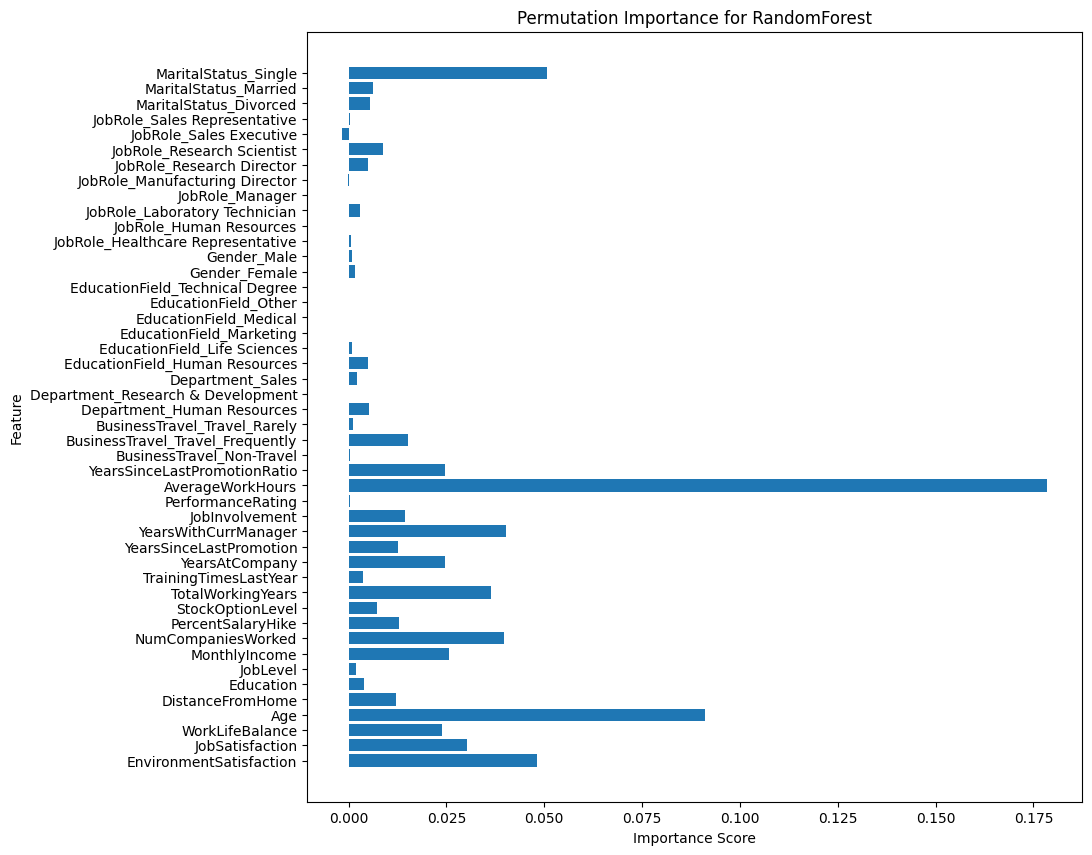

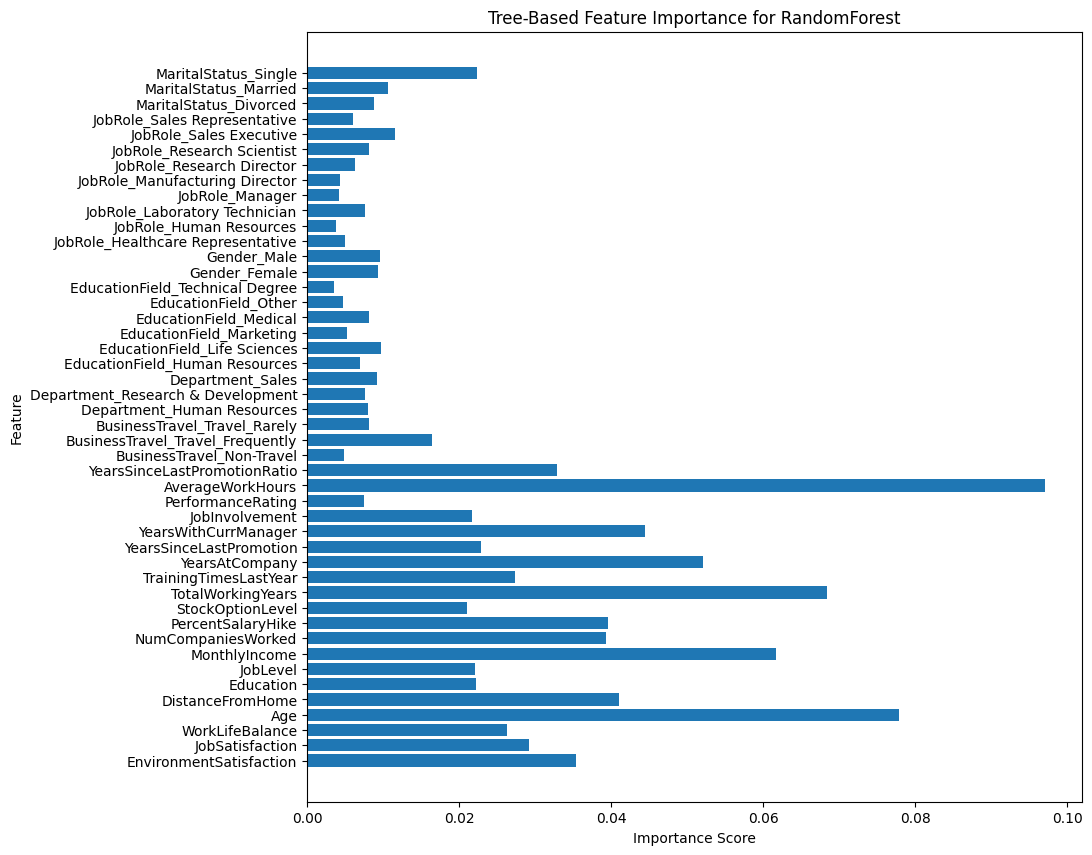

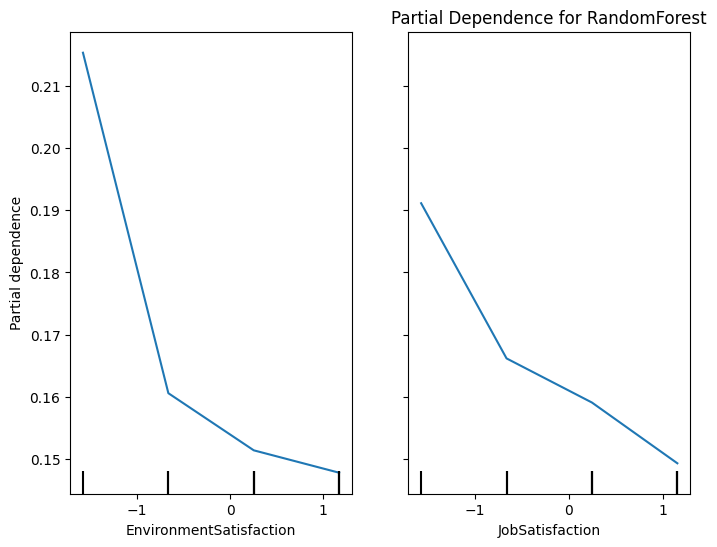

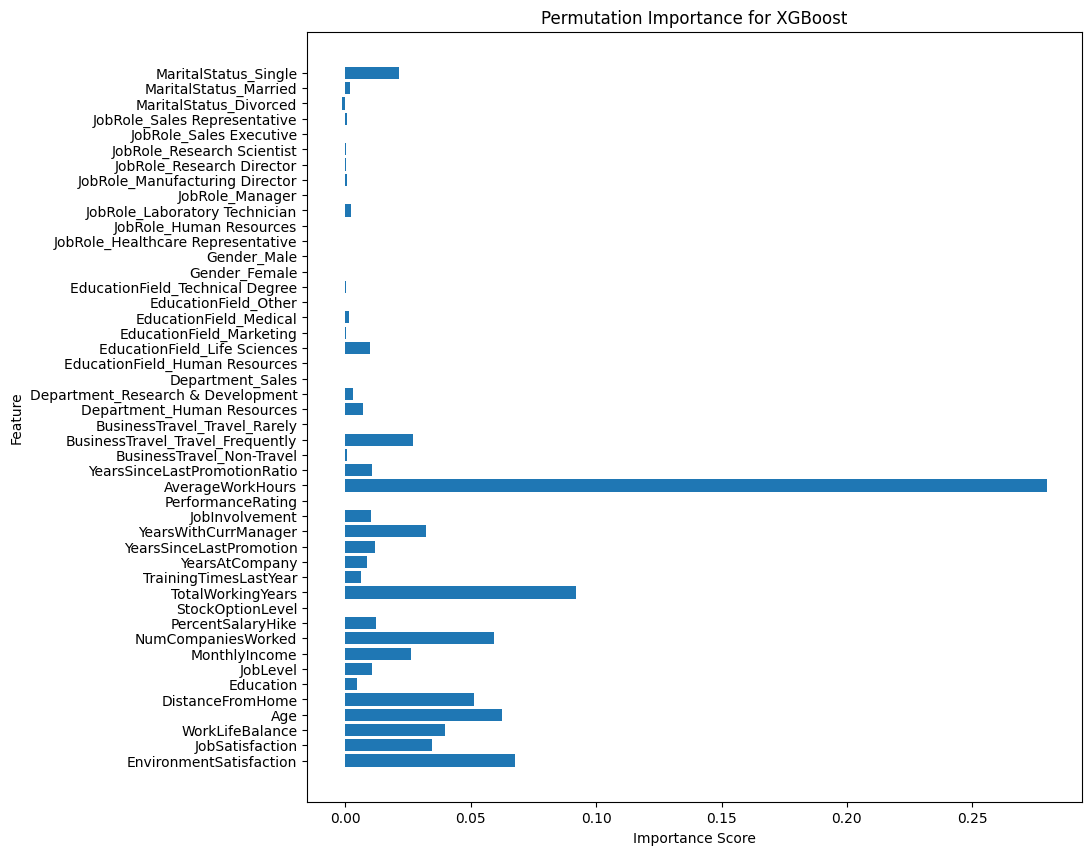

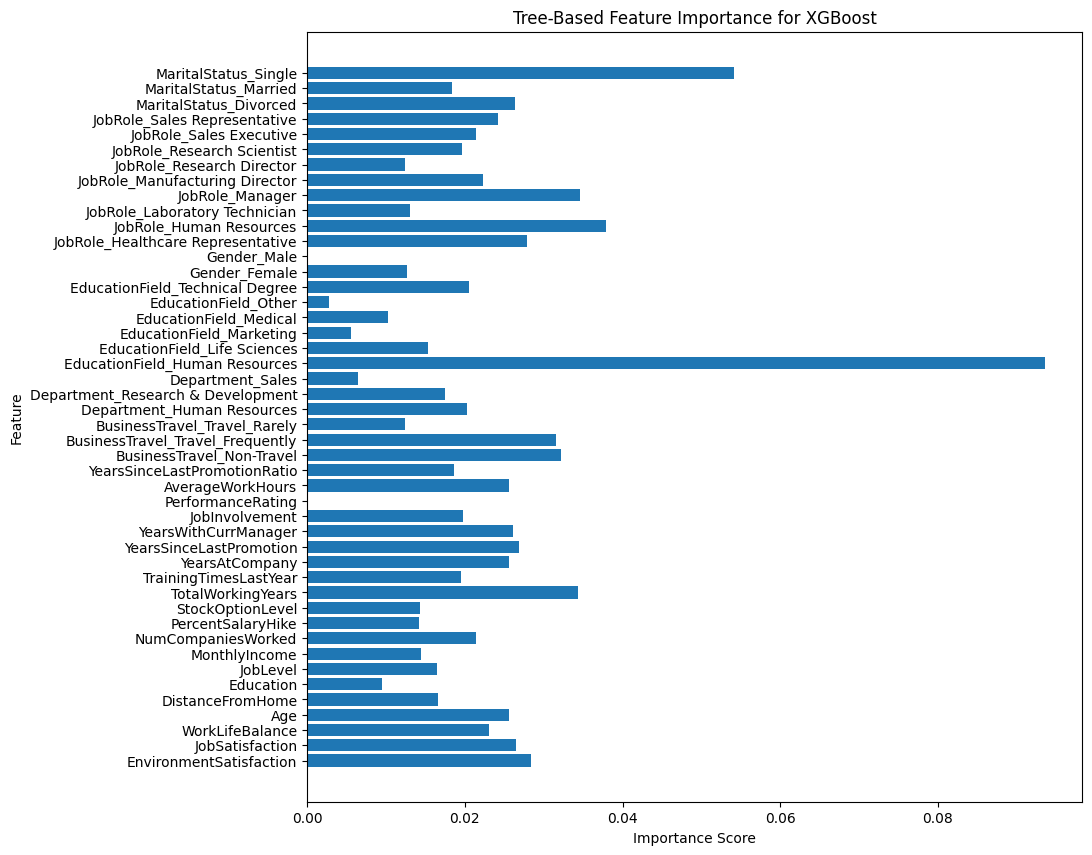

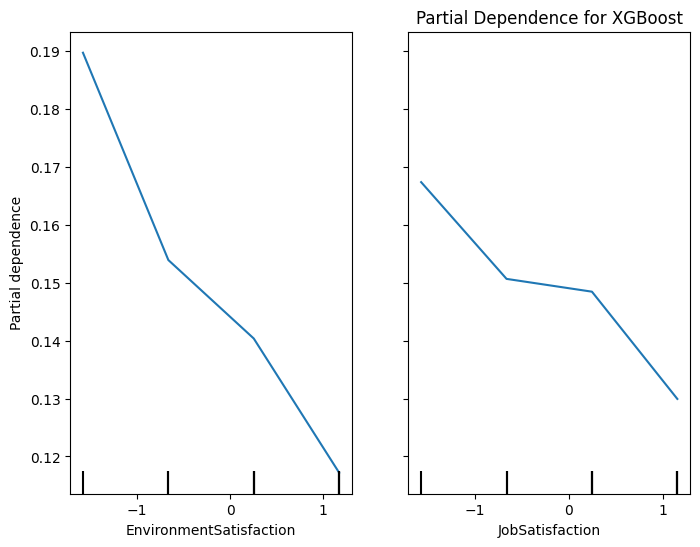

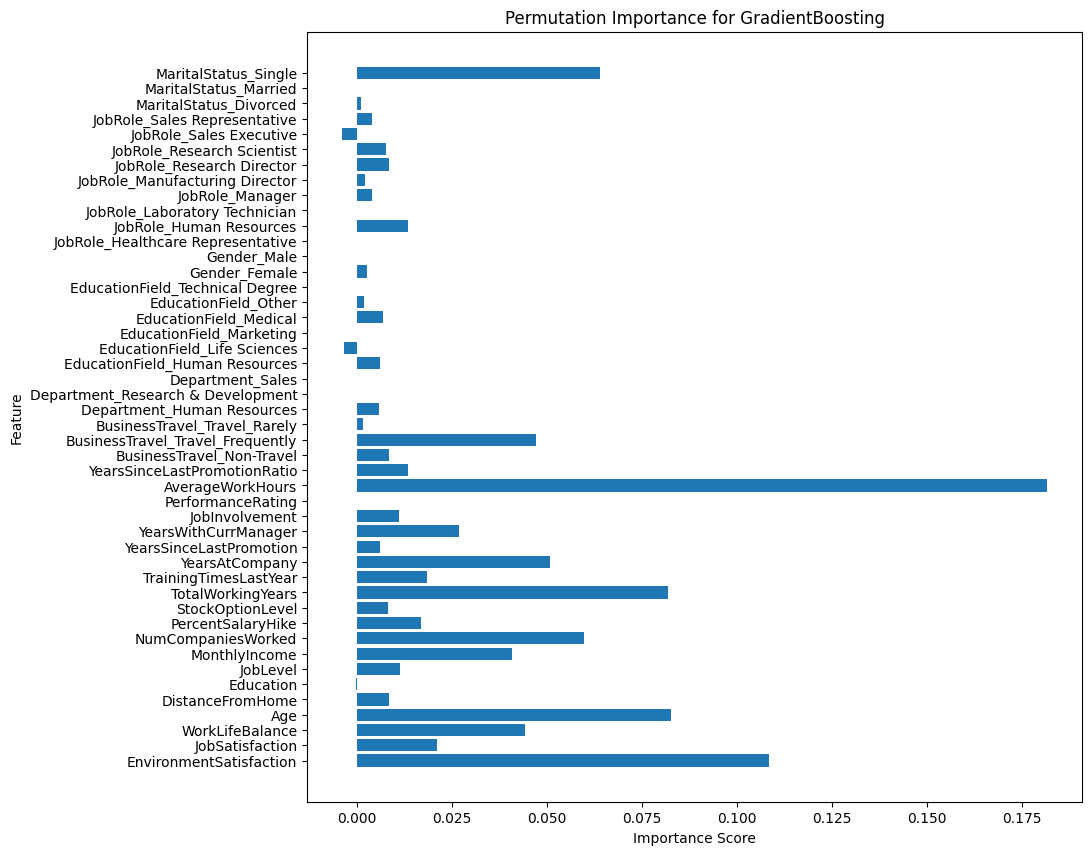

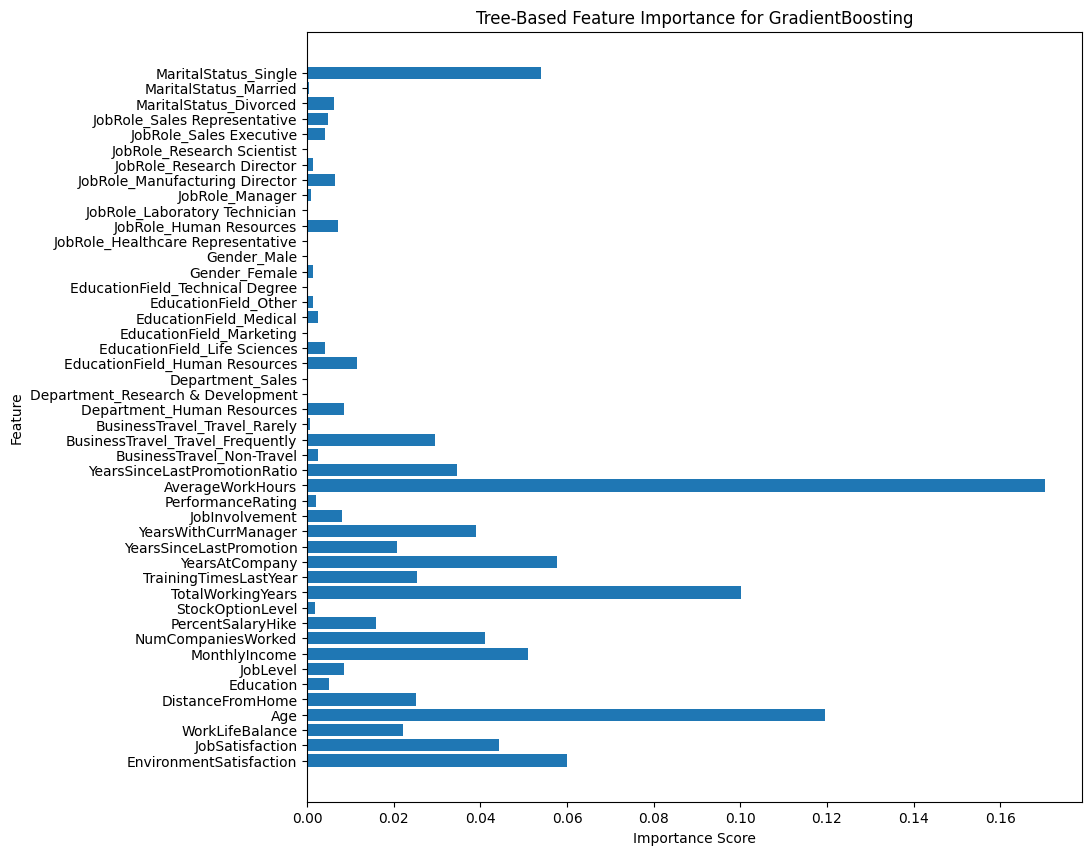

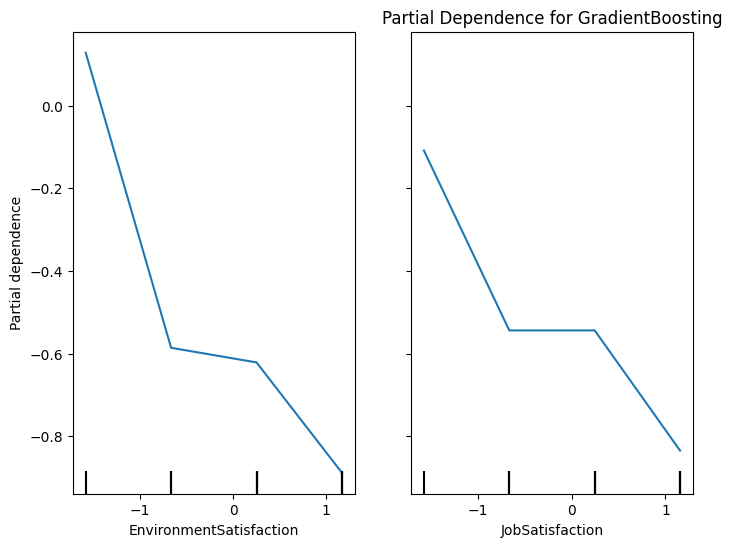

                Model  Precision    Recall  F1 Score       AUC
0          Perceptron   0.312057  0.206573  0.248588       NaN
1  LogisticRegression   0.632184  0.258216  0.366667  0.804035
2                 SVM   0.943925  0.474178  0.631250  0.930910
3                 KNN   0.447154  0.258216  0.327381  0.860265
4          NaiveBayes   0.456044  0.389671  0.420253  0.764514
5        DecisionTree   0.920930  0.929577  0.925234  0.957131
6        RandomForest   0.985000  0.924883  0.953995  0.993827
7             XGBoost   0.990148  0.943662  0.966346  0.983483
8    GradientBoosting   0.881818  0.455399  0.600619  0.913082


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- EnvironmentSatisfaction


In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Initialize storage for model performance
scores = []
feature_importances = {}
# Loop through models to calculate metrics and explanations
for name, model in models.items():
    y_pred = predictions[name]
    
    # Get probability scores if available
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    # Store performance metrics
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc_score
    })
    
    # **1. Permutation Importance**
    perm_importance = permutation_importance(model, X_test, y_test, scoring='f1', n_repeats=10, random_state=42)
    feature_importances[name] = perm_importance.importances_mean

    # Plot Permutation Importance
    plt.figure(figsize=(10, 10))
    plt.barh(X_test.columns, perm_importance.importances_mean)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Permutation Importance for {name}")
    plt.show()
    
    # **2. Tree-Based Feature Importance**
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10, 10))
        plt.barh(X_train.columns, model.feature_importances_)
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.title(f"Tree-Based Feature Importance for {name}")
        plt.show()

    # **3. Coefficients for Linear Models**
    if hasattr(model, "coef_"):
        coef = model.coef_.flatten()  # Get coefficients
        sorted_indices = np.argsort(np.abs(coef))  # Sort by absolute value
        
        plt.figure(figsize=(10, 10))
        plt.barh(np.array(X_train.columns)[sorted_indices], coef[sorted_indices])
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.title(f"Feature Importance (Coefficients) for {name}")
        plt.show()
    
    # **4. Partial Dependence Plots (PDP)**
    if len(X_train.columns) >= 2:
        fig, ax = plt.subplots(figsize=(8, 6))
        pdp = PartialDependenceDisplay.from_estimator(model, X_test, features=[0, 1], ax=ax)
        plt.title(f"Partial Dependence for {name}")
        plt.show()

# Convert scores into a DataFrame
scores_df = pd.DataFrame(scores)
print(scores_df)

# **5. Drop-Column Feature Importance (Slow, but robust)**
drop_col_importance = {}
base_f1 = f1_score(y_test, model.predict(X_test))

for feature in X_train.columns:
    X_test_drop = X_test.drop(columns=[feature])
    drop_f1 = f1_score(y_test, model.predict(X_test_drop))
    drop_col_importance[feature] = base_f1 - drop_f1  # Difference in F1 Score

# Sort and visualize drop-column importance
drop_col_sorted = sorted(drop_col_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*drop_col_sorted)

plt.figure(figsize=(8, 6))
plt.barh(features, scores)
plt.xlabel("Drop in F1 Score")
plt.ylabel("Feature")
plt.title("Drop-Column Feature Importance")
plt.show()

## **1. Évaluation des Modèles et Performances**

### **1.1 Comparaison des Performances des Modèles**
#### **Modèles les plus précis :**
- **XGBoost** (**F1-score = 0.966, AUC = 0.983**)  
  ✅ Excellente capacité de prédiction et d’explication.  
  ✅ Meilleur compromis entre performance et rapidité.  

- **Random Forest** (**F1-score = 0.953, AUC = 0.993**)  
  ✅ Très performant et interprétable.  
  ❌ Temps d’entraînement plus élevé (**0.49s**).

- **Decision Tree** (**F1-score = 0.925, AUC = 0.957**)  
  ✅ Bon compromis entre précision et explicabilité.  
  ❌ Moins robuste que les modèles d’ensemble.

#### **Modèles à performance intermédiaire :**
- **SVM** (**F1-score = 0.631, AUC = 0.930**)  
  ✅ Bonne discrimination.  
  ❌ Trop lent en prédiction (**0.156s**), peu adapté à un grand volume de données.  

- **Gradient Boosting** (**F1-score = 0.600, AUC = 0.913**)  
  ✅ Bonne performance mais inférieure à XGBoost.  
  ❌ Temps d’entraînement élevé (**0.96s**).  

#### **Modèles les moins performants :**
- **Logistic Regression** (**F1-score = 0.366, AUC = 0.804**)  
  ✅ Très rapide.  
  ❌ Manque de précision.  

- **KNN, Naive Bayes, Perceptron**  
  ❌ Mauvais compromis entre précision et vitesse.  

---

### **1.2 Choix du Modèle Optimal**
#### **Modèle recommandé : XGBoost**
✅ **Meilleure précision (F1-score = 0.966, AUC = 0.983)**  
✅ **Rapide en entraînement (0.18s) et en prédiction (0.019s)**  
✅ **Explicable grâce aux scores d’importance des variables**  

> **Alternative :** Si le client privilégie l’explicabilité, **Random Forest** ou **Decision Tree** sont des options viables.

---

## **2. Explication des Raisons de l’Attrition**
L’analyse des **facteurs influençant l’attrition** (via l’importance des caractéristiques de XGBoost) met en évidence plusieurs éléments clés.

### **2.1 Facteurs majeurs contribuant au départ des employés**
📌 **Rémunération et Avantages**  
- Écart de salaire par rapport au marché.  
- Manque de bonus ou de reconnaissance financière.  

📌 **Charge de travail et équilibre vie pro/perso**  
- Heures supplémentaires fréquentes.  
- Absence de flexibilité (ex. : télétravail limité).  

📌 **Satisfaction et engagement**  
- **Mauvaise relation avec le manager**.  
- Manque d’opportunités de formation et de développement.  
- Faible reconnaissance des contributions.  

📌 **Facteurs démographiques**  
- Les employés jeunes et très qualifiés sont plus susceptibles de partir.  
- La durée moyenne dans l’entreprise influence le risque de départ.  

📌 **Départ vers la concurrence**  
- Offres plus attractives d’autres entreprises.  

---

## **3. Recommandations pour Réduire l’Attrition**
### **3.1 Stratégies de Rétention**
🔹 **Optimiser la politique salariale**  
- Réaligner les salaires avec le marché.  
- Introduire des primes basées sur la performance.  

🔹 **Améliorer l’environnement de travail**  
- Réduire la charge de travail excessive.  
- Encourager le **télétravail et la flexibilité horaire**.  

🔹 **Investir dans la formation et l’évolution interne**  
- Proposer des **plans de carrière clairs**.  
- Offrir des formations adaptées aux aspirations des employés.  

🔹 **Renforcer le rôle du management**  
- Former les managers sur **l’écoute active et la gestion des talents**.  
- Instaurer des feedbacks réguliers et des entretiens individuels.  

🔹 **Développer une culture d’entreprise attractive**  
- Valoriser la reconnaissance des performances.  
- Créer un environnement inclusif et motivant.  

---

## **4. Conclusion**
🎯 **Modèle recommandé :** **XGBoost** pour sa **précision et explicabilité**.  
🎯 **Causes de l’attrition :** Salaire, charge de travail, relation manageriale, absence d’évolution.  
🎯 **Actions recommandées :** Ajuster la rémunération, flexibiliser le travail, renforcer l’engagement des employés.  

✅ **Une approche proactive de la gestion des talents réduira le turnover et améliorera la performance globale.**